In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')


email_df = pd.read_csv('email_table.csv')
opened_df = pd.read_csv('email_opened_table.csv')
clicked_df = pd.read_csv('link_clicked_table.csv')

email_df.drop_duplicates(inplace=True)
email_df.dropna(inplace=True)


email_df['hour'] = email_df['hour'].astype(int)
email_df['time_of_day'] = pd.cut(
    email_df['hour'],
    bins=[0, 5, 11, 16, 20, 24],
    labels=['Late Night', 'Morning', 'Afternoon', 'Evening', 'Night']
)


email_df['is_weekend'] = email_df['weekday'].isin(['Saturday', 'Sunday']).astype(int)


email_df['opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)


email_df['clicked_if_opened'] = 0
email_df.loc[email_df['opened'] == 1, 'clicked_if_opened'] = email_df.loc[email_df['opened'] == 1, 'clicked']


email_df['email_length'] = np.where(email_df['email_text'] == 'long_email', 1, 0)
email_df['is_personalized'] = np.where(email_df['email_version'] == 'personalized', 1, 0)


email_df['purchase_segment'] = pd.qcut(
    email_df['user_past_purchases'],
    q=5,
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)


email_df['engagement_score'] = (email_df['user_past_purchases'] * 0.7) + (email_df['opened'] * 0.3)


click_rate = email_df['clicked'].mean()
print(f"Click rate: {click_rate:.4f} ({click_rate*100:.2f}%)")

# If click rate is very low, we have a significant class imbalance problem
is_imbalanced = click_rate < 0.1
print(f"Class imbalance detected: {is_imbalanced}")

Click rate: 0.0212 (2.12%)
Class imbalance detected: True


EDA

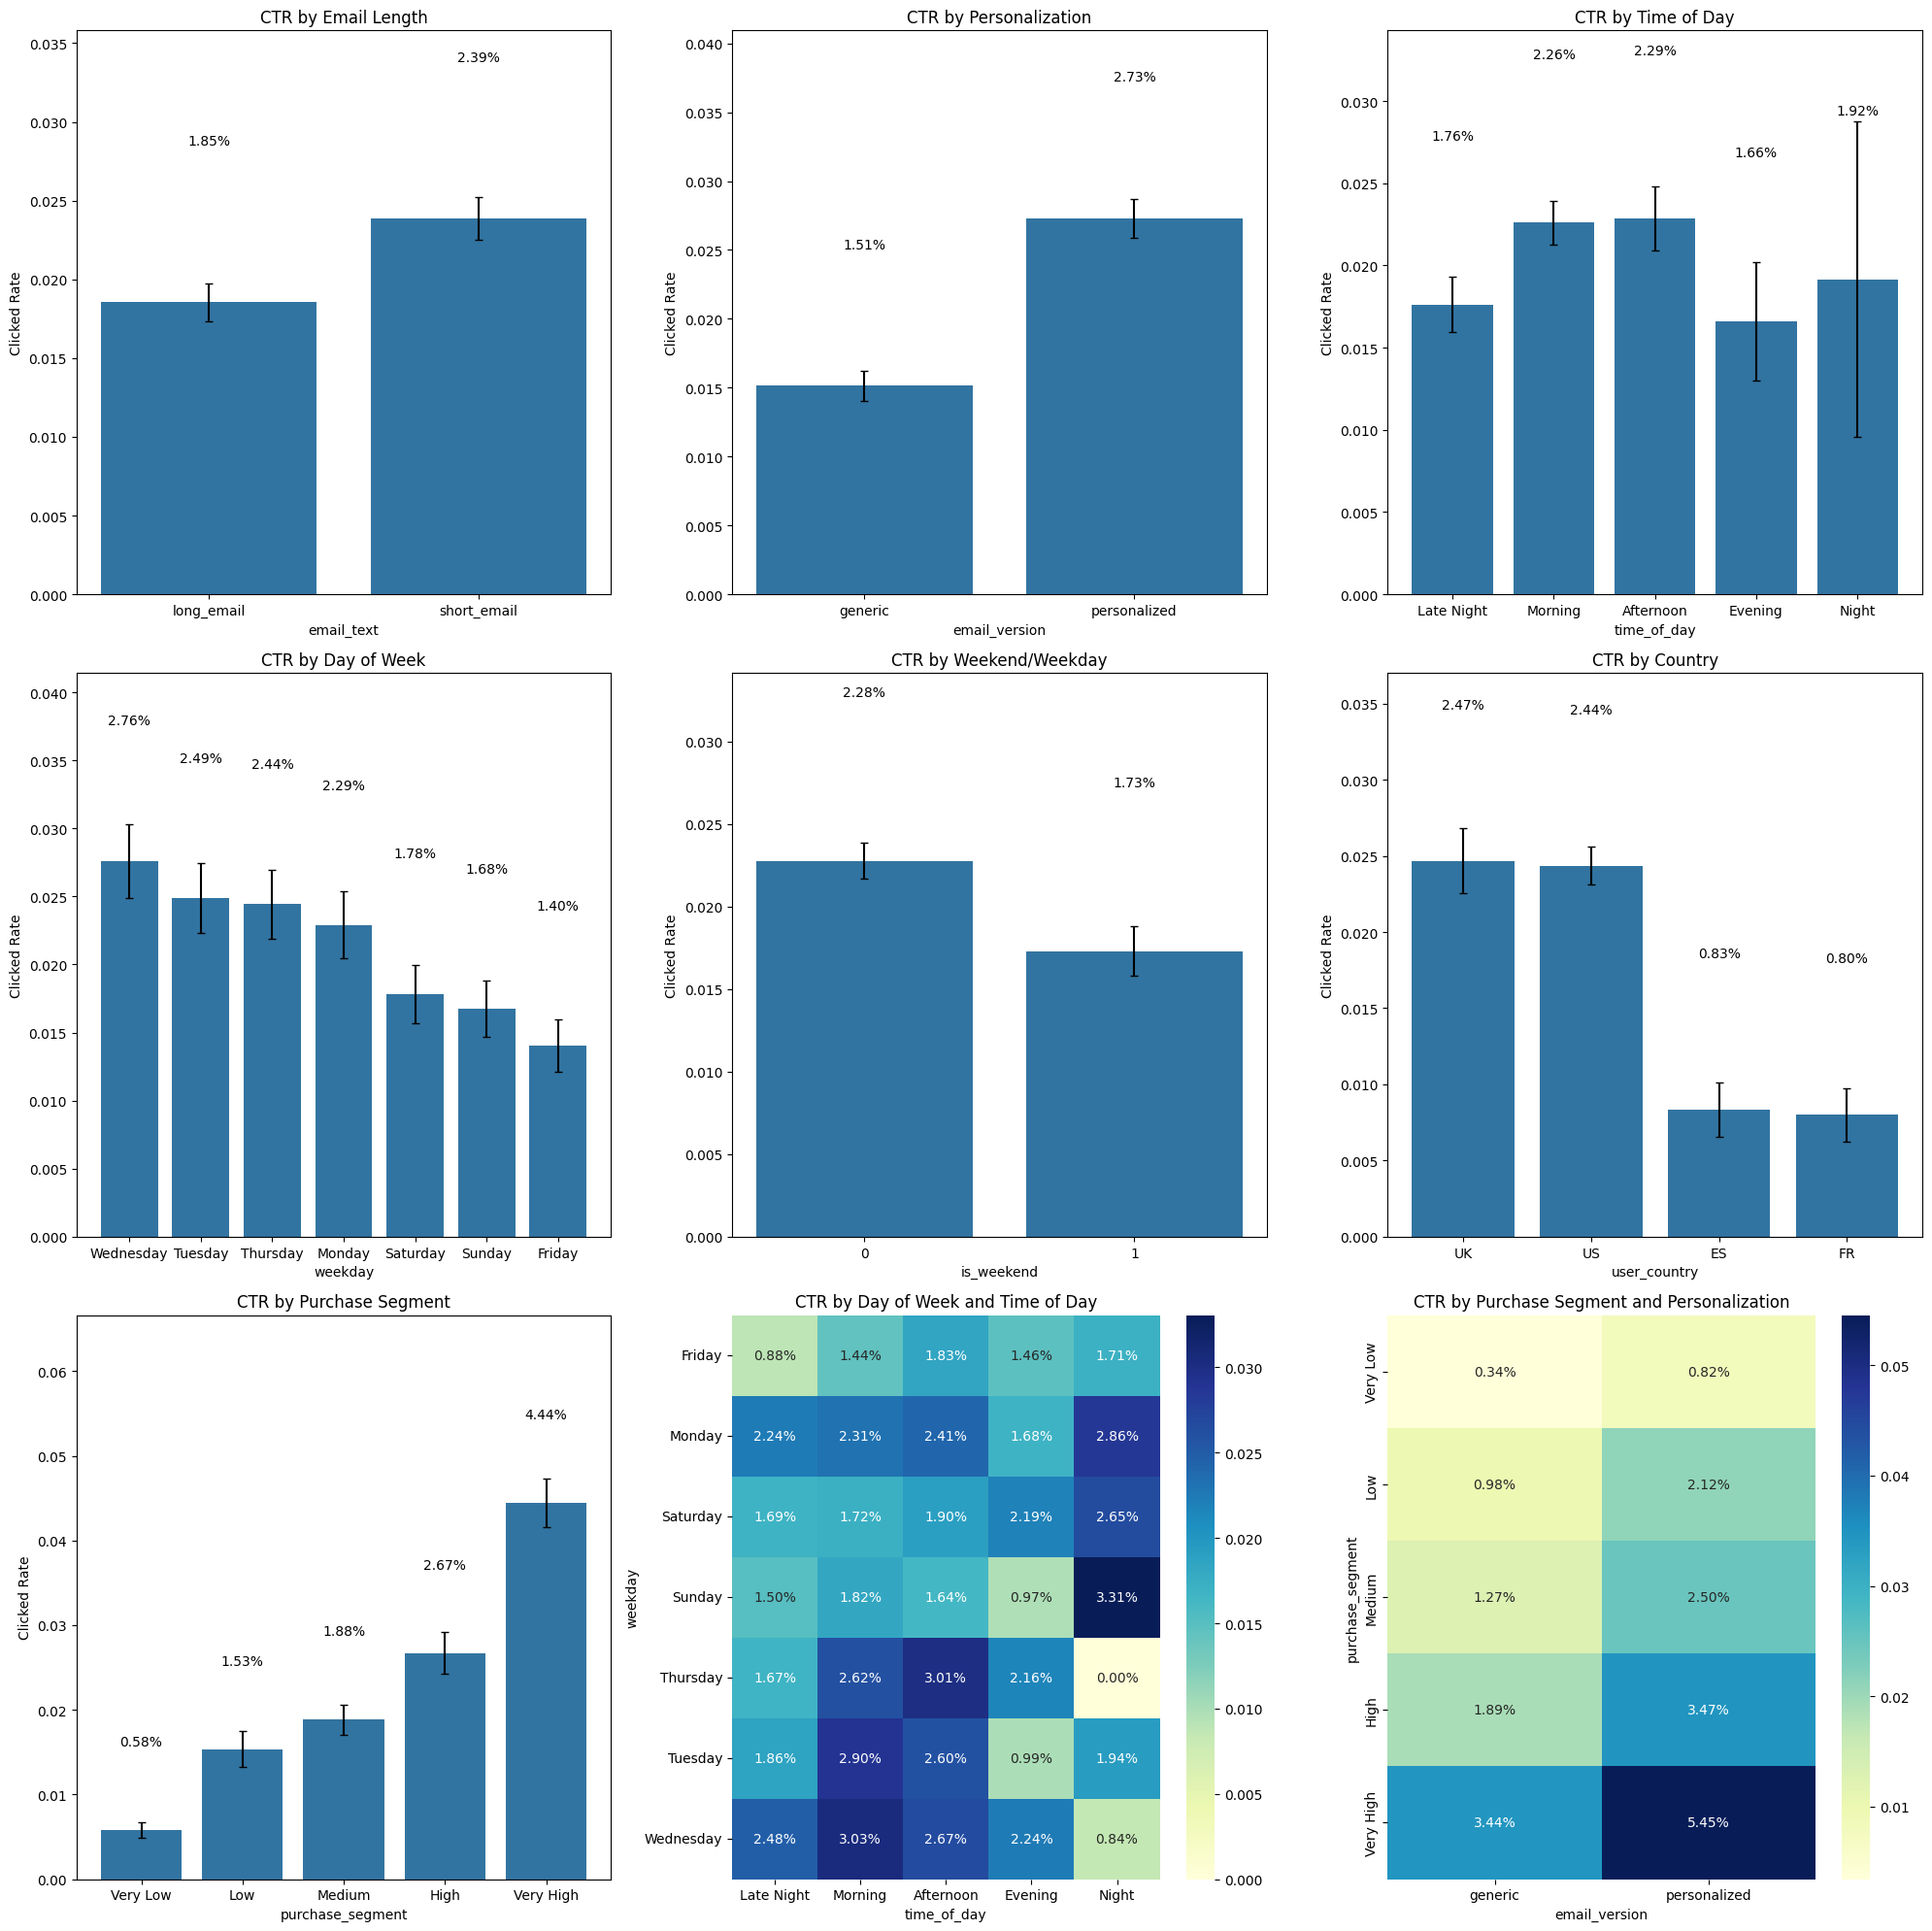


Statistical Significance Tests:
Email Length (Short vs Long): p-value = 0.0000, Significant: True
Personalization: p-value = 0.0000, Significant: True
Weekend Effect: p-value = 0.0000, Significant: True


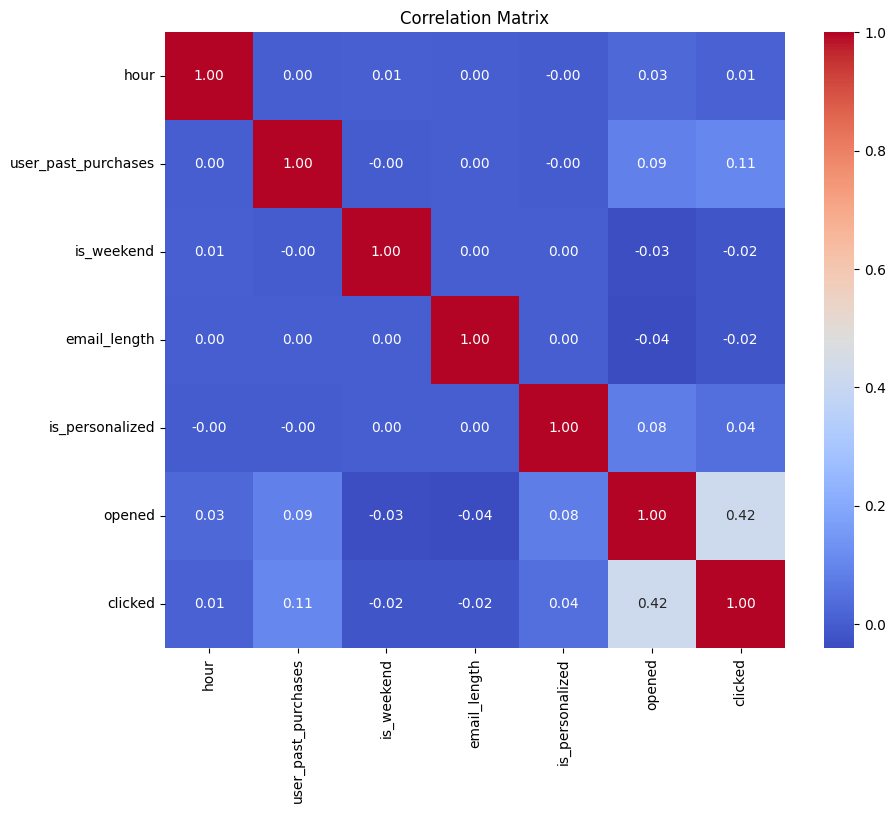

In [2]:

def plot_metric_with_ci(df, x_col, target_col, title, ax, sort=False):

    grouped = df.groupby(x_col)[target_col].agg(['mean', 'count'])
    grouped['se'] = np.sqrt(grouped['mean'] * (1 - grouped['mean']) / grouped['count'])
    grouped['ci_lower'] = grouped['mean'] - 1.96 * grouped['se']
    grouped['ci_upper'] = grouped['mean'] + 1.96 * grouped['se']

    if sort:
        grouped = grouped.sort_values('mean', ascending=False)

    # Plot
    sns.barplot(x=grouped.index, y='mean', data=grouped, ax=ax)


    for i, (idx, row) in enumerate(grouped.iterrows()):
        ax.errorbar(i, row['mean'], yerr=row['se']*1.96, fmt='none', color='black', capsize=3)

    ax.set_title(title)
    ax.set_ylabel(f'{target_col.title()} Rate')
    ax.set_ylim(0, min(1, grouped['mean'].max() * 1.5))


    for i, v in enumerate(grouped['mean']):
        ax.text(i, v + 0.01, f'{v:.2%}', ha='center')

plt.figure(figsize=(20, 20))


ax1 = plt.subplot(3, 3, 1)
plot_metric_with_ci(email_df, 'email_text', 'clicked', 'CTR by Email Length', ax1)


ax2 = plt.subplot(3, 3, 2)
plot_metric_with_ci(email_df, 'email_version', 'clicked', 'CTR by Personalization', ax2)


ax3 = plt.subplot(3, 3, 3)
plot_metric_with_ci(email_df, 'time_of_day', 'clicked', 'CTR by Time of Day', ax3)


ax4 = plt.subplot(3, 3, 4)
plot_metric_with_ci(email_df, 'weekday', 'clicked', 'CTR by Day of Week', ax4, sort=True)


ax5 = plt.subplot(3, 3, 5)
plot_metric_with_ci(email_df, 'is_weekend', 'clicked', 'CTR by Weekend/Weekday', ax5)


ax6 = plt.subplot(3, 3, 6)
plot_metric_with_ci(email_df, 'user_country', 'clicked', 'CTR by Country', ax6, sort=True)


ax7 = plt.subplot(3, 3, 7)
plot_metric_with_ci(email_df, 'purchase_segment', 'clicked', 'CTR by Purchase Segment', ax7)


ax8 = plt.subplot(3, 3, 8)
pivot_data = pd.pivot_table(
    email_df,
    values='clicked',
    index='weekday',
    columns='time_of_day',
    aggfunc='mean'
)
sns.heatmap(pivot_data, annot=True, fmt='.2%', cmap='YlGnBu', ax=ax8)
ax8.set_title('CTR by Day of Week and Time of Day')

# 9. Purchase history vs personalization interaction
ax9 = plt.subplot(3, 3, 9)
pivot_data2 = pd.pivot_table(
    email_df,
    values='clicked',
    index='purchase_segment',
    columns='email_version',
    aggfunc='mean'
)
sns.heatmap(pivot_data2, annot=True, fmt='.2%', cmap='YlGnBu', ax=ax9)
ax9.set_title('CTR by Purchase Segment and Personalization')

plt.tight_layout()
plt.savefig('email_campaign_detailed_analysis.png', dpi=300)
plt.show()


print("\nStatistical Significance Tests:\n" + "="*30)

# Test for email format
grp1 = email_df[email_df['email_text'] == 'short_email']['clicked']
grp2 = email_df[email_df['email_text'] == 'long_email']['clicked']
_, p_val = stats.ttest_ind(grp1, grp2, equal_var=False)
print(f"Email Length (Short vs Long): p-value = {p_val:.4f}, Significant: {p_val < 0.05}")


grp1 = email_df[email_df['email_version'] == 'personalized']['clicked']
grp2 = email_df[email_df['email_version'] == 'generic']['clicked']
_, p_val = stats.ttest_ind(grp1, grp2, equal_var=False)
print(f"Personalization: p-value = {p_val:.4f}, Significant: {p_val < 0.05}")


grp1 = email_df[email_df['is_weekend'] == 1]['clicked']
grp2 = email_df[email_df['is_weekend'] == 0]['clicked']
_, p_val = stats.ttest_ind(grp1, grp2, equal_var=False)
print(f"Weekend Effect: p-value = {p_val:.4f}, Significant: {p_val < 0.05}")

# Correlation matrix for numerical features
correlation = email_df[['hour', 'user_past_purchases', 'is_weekend', 'email_length',
                       'is_personalized', 'opened', 'clicked']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()

Feature Engineering

In [3]:
# Create interaction features
email_df['personalized_x_weekend'] = email_df['is_personalized'] * email_df['is_weekend']
email_df['personalized_x_purchases'] = email_df['is_personalized'] * email_df['user_past_purchases']
email_df['length_x_time'] = email_df['email_length'] * email_df['hour']

# Encode categorical variables properly
categorical_features = ['email_text', 'email_version', 'weekday', 'user_country', 'time_of_day', 'purchase_segment']
numerical_features = ['hour', 'user_past_purchases', 'is_weekend', 'personalized_x_weekend',
                     'personalized_x_purchases', 'length_x_time']

# Create preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data for modeling
X = email_df.drop(['email_id', 'opened', 'clicked', 'clicked_if_opened', 'engagement_score'], axis=1)
y = email_df['clicked']

# Split train/test with stratification to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply preprocessing to training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_train_resampled, y_train_resampled = X_train_processed, y_train


model development with ensemble


Tuning Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.7382

Tuning Random Forest...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.7275

Tuning Gradient Boosting...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV score: 0.7418

Tuning XGBoost...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV score: 0.7423

Tuning LightGBM...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Number of positive: 1695, 

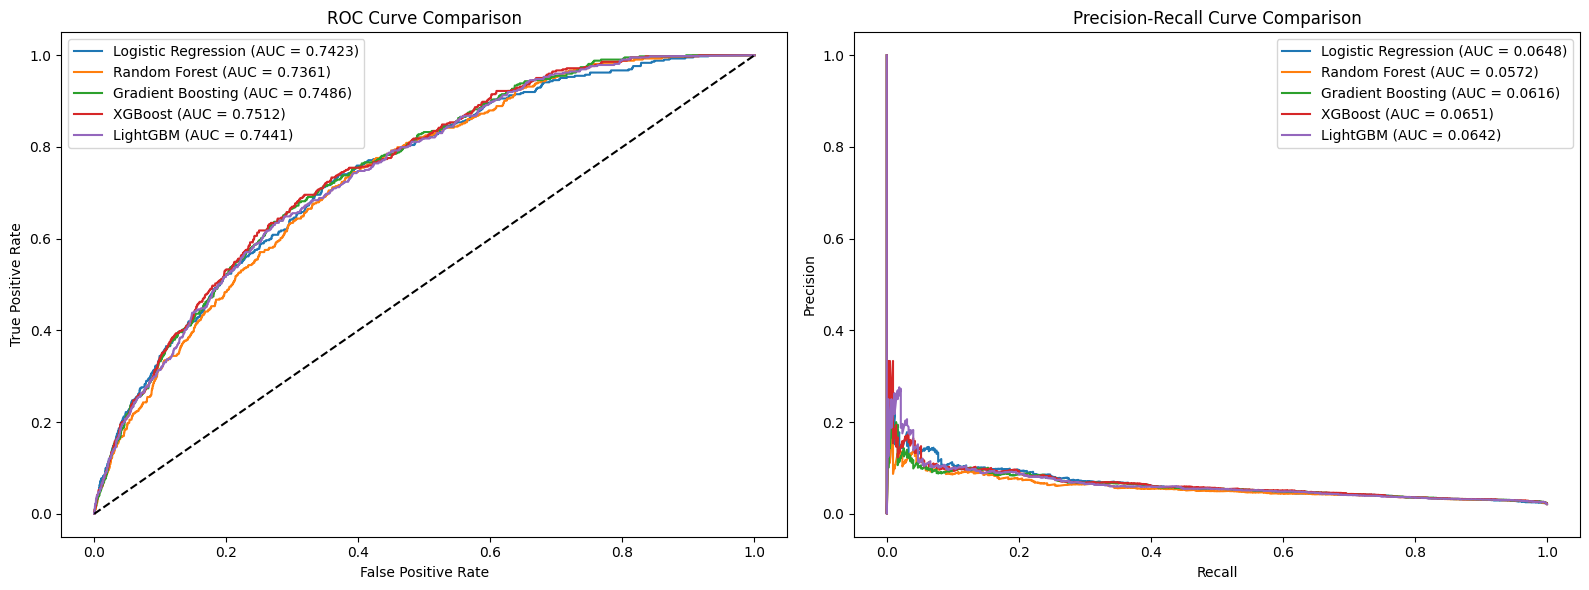

In [4]:
# Define evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Classification metrics
    print(f"\nModel: {model_name}")
    print(classification_report(y_test, y_pred))

    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Precision-Recall AUC (better metric for imbalanced classes)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    print(f"PR AUC: {pr_auc:.4f}")

    return y_pred_proba, roc_auc, pr_auc

# Hyperparameter tuning using GridSearchCV
def tune_model(model, param_grid, X_train, y_train, model_name):
    print(f"\nTuning {model_name}...")

    # Define the cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Create grid search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    # Fit grid search
    grid_search.fit(X_train, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

# Train multiple models
models = {}

# 1. Logistic Regression
lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}
lr_model = LogisticRegression(random_state=42, max_iter=1000)
models['Logistic Regression'] = tune_model(lr_model, lr_params, X_train_resampled, y_train_resampled, "Logistic Regression")

# 2. Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}
rf_model = RandomForestClassifier(random_state=42)
models['Random Forest'] = tune_model(rf_model, rf_params, X_train_resampled, y_train_resampled, "Random Forest")

# 3. Gradient Boosting
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}
gb_model = GradientBoostingClassifier(random_state=42)
models['Gradient Boosting'] = tune_model(gb_model, gb_params, X_train_resampled, y_train_resampled, "Gradient Boosting")

# 4. XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
models['XGBoost'] = tune_model(xgb_model, xgb_params, X_train_resampled, y_train_resampled, "XGBoost")

# 5. LightGBM
lgbm_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 127],
    'subsample': [0.8, 1.0]
}
lgbm_model = LGBMClassifier(random_state=42)
models['LightGBM'] = tune_model(lgbm_model, lgbm_params, X_train_resampled, y_train_resampled, "LightGBM")

# Evaluate all models on test set
results = {}
for name, model in models.items():
    y_pred_proba, roc_auc, pr_auc = evaluate_model(model, X_test_processed, y_test, name)
    results[name] = {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'predictions': y_pred_proba
    }

# Find the best model
best_model_name = max(results.items(), key=lambda x: x[1]['roc_auc'])[0]
print(f"\nBest model based on ROC AUC: {best_model_name}")
best_model = models[best_model_name]

# Plot ROC and PR curves for all models
plt.figure(figsize=(16, 6))

# ROC curve
plt.subplot(1, 2, 1)
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['predictions'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['roc_auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()

# PR curve
plt.subplot(1, 2, 2)
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['predictions'])
    plt.plot(recall, precision, label=f"{name} (AUC = {result['pr_auc']:.4f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()

feature importance analysis



Feature ranking:
1. purchase_segment_Very High (0.1915)
2. purchase_segment_Very Low (0.1416)
3. personalized_x_purchases (0.0787)
4. user_past_purchases (0.0779)
5. user_country_FR (0.0430)
6. email_version_generic (0.0421)
7. user_country_ES (0.0419)
8. weekday_Wednesday (0.0315)
9. time_of_day_Morning (0.0311)
10. email_text_long_email (0.0308)
11. weekday_Friday (0.0297)
12. is_weekend (0.0252)
13. user_country_US (0.0249)
14. time_of_day_Evening (0.0190)
15. hour (0.0186)
16. weekday_Sunday (0.0182)
17. email_text_short_email (0.0181)
18. weekday_Thursday (0.0177)
19. user_country_UK (0.0176)
20. length_x_time (0.0172)


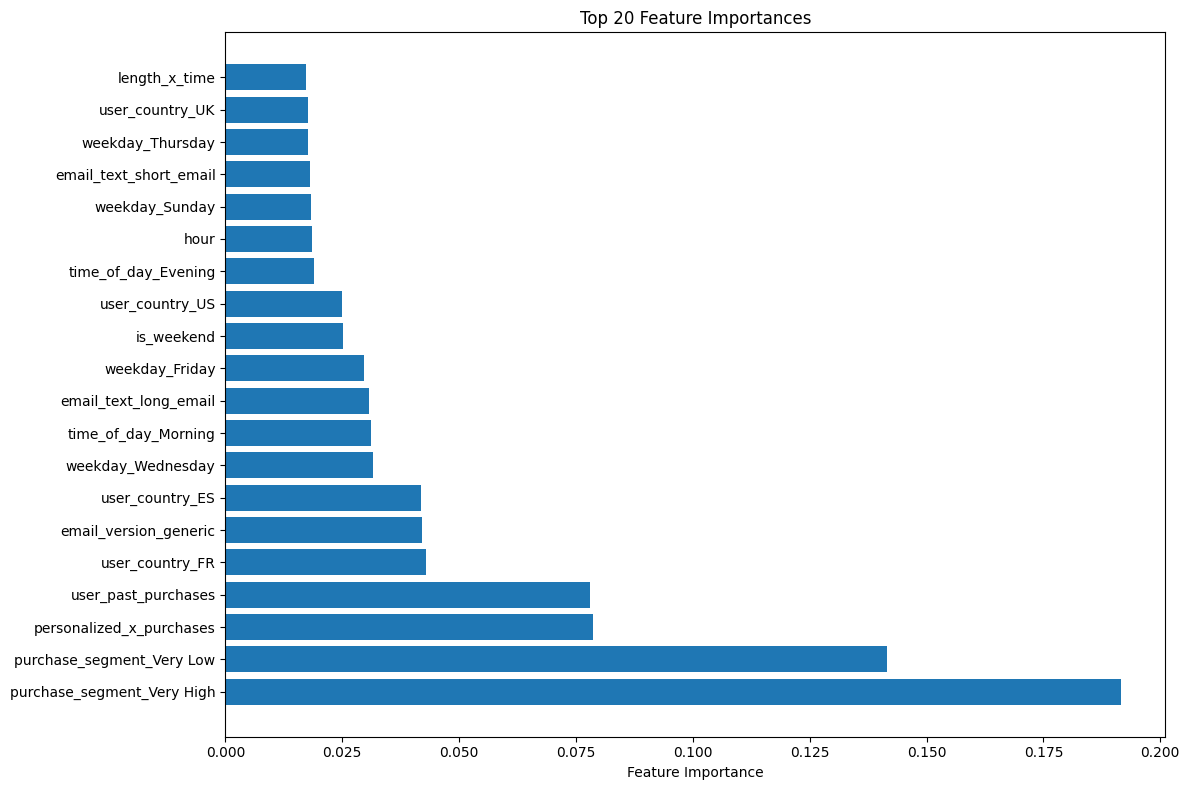

In [5]:
# Get feature names after preprocessing
preprocessor.fit(X_train)
all_features = []

# Get numerical feature names (these stay the same)
all_features.extend(numerical_features)

# Get one-hot encoded feature names
for i, feature in enumerate(categorical_features):
    categories = preprocessor.transformers_[1][1].named_steps['onehot'].categories_[i]
    for category in categories:
        all_features.append(f"{feature}_{category}")

# Plot feature importance for tree-based models
if hasattr(best_model, 'feature_importances_'):

    importances = best_model.feature_importances_


    indices = np.argsort(importances)[::-1]


    print("\nFeature ranking:")
    for f in range(min(20, len(all_features))):
        if f < len(indices):
            print(f"{f+1}. {all_features[indices[f]]} ({importances[indices[f]]:.4f})")


    plt.figure(figsize=(12, 8))
    plt.barh(range(min(20, len(indices))), importances[indices][:20], align='center')
    plt.yticks(range(min(20, len(indices))), [all_features[i] for i in indices][:20])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300)
    plt.show()
elif isinstance(best_model, LogisticRegression):

    coef = best_model.coef_[0]


    indices = np.argsort(np.abs(coef))[::-1]

    # Print feature ranking
    print("\nFeature ranking (absolute coefficient value):")
    for f in range(min(20, len(all_features))):
        if f < len(indices):
            print(f"{f+1}. {all_features[indices[f]]} ({coef[indices[f]]:.4f})")

    # Plot feature coefficients
    plt.figure(figsize=(12, 8))
    plt.barh(range(min(20, len(indices))), coef[indices][:20], align='center')
    plt.yticks(range(min(20, len(indices))), [all_features[i] for i in indices][:20])
    plt.xlabel('Coefficient Value')
    plt.title('Top 20 Feature Coefficients')
    plt.tight_layout()
    plt.savefig('feature_coefficients.png', dpi=300)
    plt.show()

 Model Insights with SHAP


Generating SHAP values for model explanation...


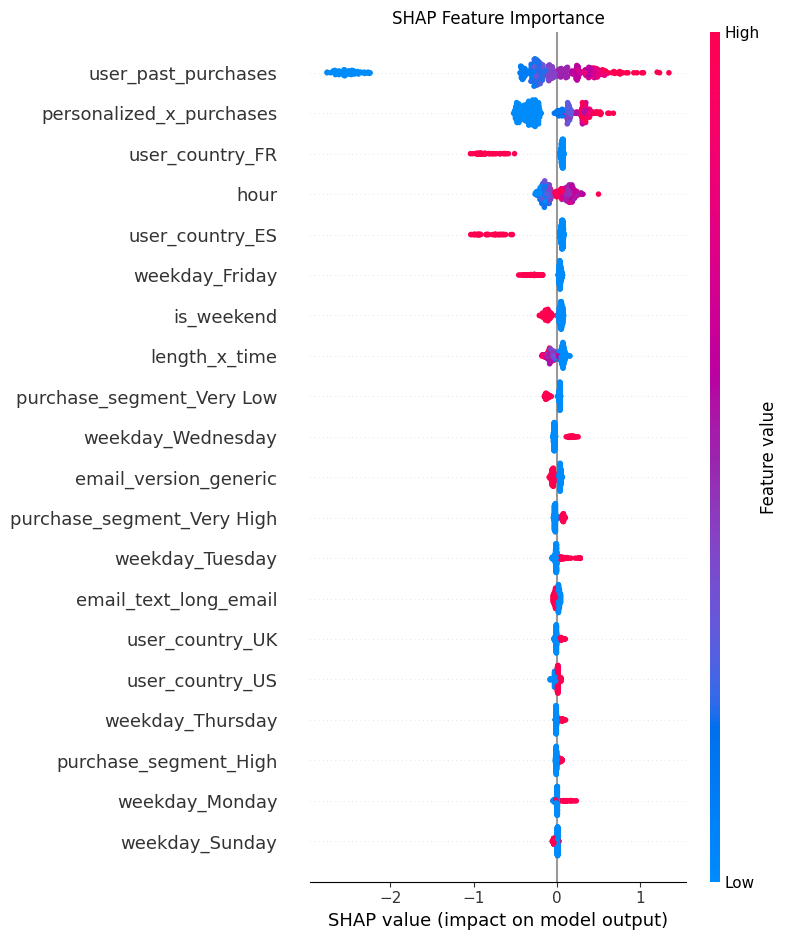

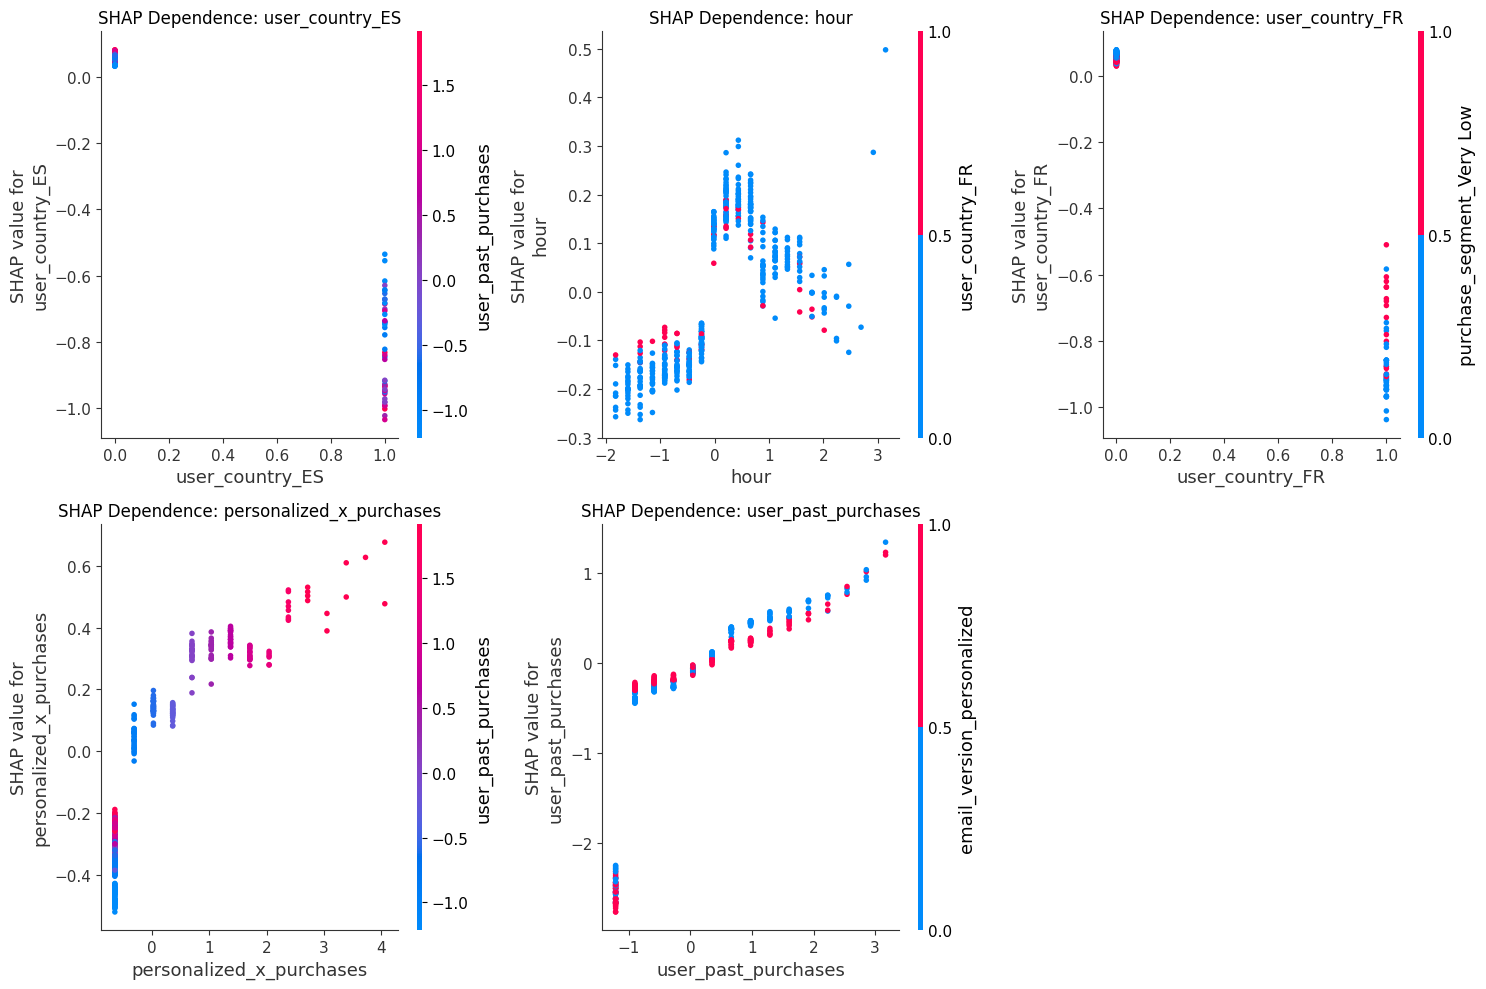

In [6]:
import shap


if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
    print("\nGenerating SHAP values for model explanation...")

    explainer = shap.TreeExplainer(best_model)

    sample_size = min(500, X_test_processed.shape[0])
    sample_indices = np.random.choice(X_test_processed.shape[0], sample_size, replace=False)
    X_sample = X_test_processed[sample_indices]


    shap_values = explainer.shap_values(X_sample)

    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values[1] if isinstance(shap_values, list) else shap_values,
                    X_sample, feature_names=all_features, show=False)
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.savefig('shap_summary.png', dpi=300)
    plt.show()

    # Detailed SHAP dependency plots for top features
    top_features = [all_features[i] for i in np.argsort(np.abs(shap_values[1]).mean(0))[-5:]] if isinstance(shap_values, list) else [all_features[i] for i in np.argsort(np.abs(shap_values).mean(0))[-5:]]

    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(top_features):
        plt.subplot(2, 3, i+1)
        feature_idx = all_features.index(feature)
        shap.dependence_plot(feature_idx, shap_values[1] if isinstance(shap_values, list) else shap_values,
                           X_sample, feature_names=all_features, show=False, ax=plt.gca())
        plt.title(f'SHAP Dependence: {feature}')

    plt.tight_layout()
    plt.savefig('shap_dependence.png', dpi=300)
    plt.show()

Stacking Model for Better Performance


In [7]:
from sklearn.ensemble import StackingClassifier


base_models = [
    ('rf', models['Random Forest']),
    ('gb', models['Gradient Boosting']),
    ('xgb', models['XGBoost']),
    ('lgbm', models['LightGBM'])
]

meta_learner = LogisticRegression()

# Create stacking classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)


print("\nTraining stacking model...")
stacking_model.fit(X_train_processed, y_train)


y_stack_pred_proba, roc_auc_stack, pr_auc_stack = evaluate_model(
    stacking_model, X_test_processed, y_test, "Stacking Ensemble"
)

# Compare with the previous best model
print(f"\nStacking model ROC AUC: {roc_auc_stack:.4f}")
print(f"Best individual model ({best_model_name}) ROC AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"Improvement: {(roc_auc_stack - results[best_model_name]['roc_auc']) * 100:.2f}%")

# Use the stacking model if it's better
if roc_auc_stack > results[best_model_name]['roc_auc']:
    best_model = stacking_model
    best_model_name = "Stacking Ensemble"
    results[best_model_name] = {
        'roc_auc': roc_auc_stack,
        'pr_auc': pr_auc_stack,
        'predictions': y_stack_pred_proba
    }


Training stacking model...

Model: Stacking Ensemble
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19576
           1       0.00      0.00      0.00       424

    accuracy                           0.98     20000
   macro avg       0.49      0.50      0.49     20000
weighted avg       0.96      0.98      0.97     20000

ROC AUC: 0.7475
PR AUC: 0.0635

Stacking model ROC AUC: 0.7475
Best individual model (XGBoost) ROC AUC: 0.7512
Improvement: -0.37%


Optimizing Email Campaign

Baseline CTR (random targeting): 0.0212 (2.12%)
Target top 50% (10004 users) - CTR: 0.0347 (3.47%), Improvement: 63.61%
Target top 70% (14000 users) - CTR: 0.0292 (2.92%), Improvement: 37.80%
Target top 80% (16001 users) - CTR: 0.0261 (2.61%), Improvement: 23.22%
Target top 90% (18001 users) - CTR: 0.0235 (2.35%), Improvement: 10.84%


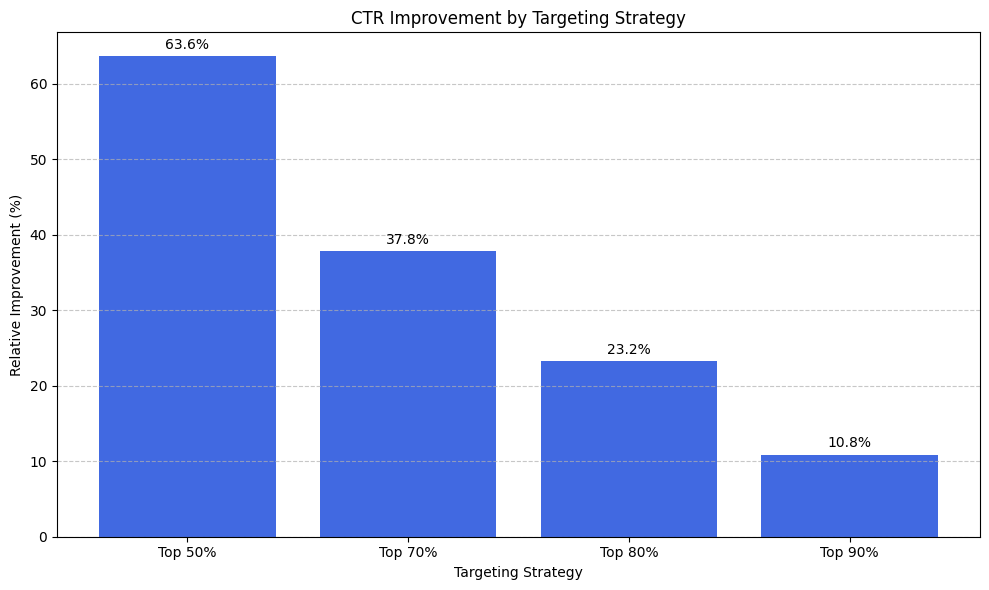

In [8]:

def estimate_campaign_improvement(model, X, y, percentiles=[50, 70, 80, 90]):

    y_pred_proba = model.predict_proba(X)[:, 1]


    baseline_ctr = y.mean()
    print(f"Baseline CTR (random targeting): {baseline_ctr:.4f} ({baseline_ctr*100:.2f}%)")


    results = []
    for p in percentiles:

        threshold = np.percentile(y_pred_proba, 100-p)

        selected = y_pred_proba >= threshold


        if sum(selected) > 0:
            targeted_ctr = y[selected].mean()
            relative_improvement = (targeted_ctr - baseline_ctr) / baseline_ctr * 100

            results.append({
                'targeting': f"Top {p}%",
                'users_targeted': sum(selected),
                'targeted_ctr': targeted_ctr,
                'relative_improvement': relative_improvement
            })

            print(f"Target top {p}% ({sum(selected)} users) - CTR: {targeted_ctr:.4f} ({targeted_ctr*100:.2f}%), Improvement: {relative_improvement:.2f}%")

    return pd.DataFrame(results)


improvement_df = estimate_campaign_improvement(best_model, X_test_processed, y_test)

# Visualize the improvement
plt.figure(figsize=(10, 6))
plt.bar(improvement_df['targeting'], improvement_df['relative_improvement'], color='royalblue')
plt.title('CTR Improvement by Targeting Strategy')
plt.xlabel('Targeting Strategy')
plt.ylabel('Relative Improvement (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(improvement_df['relative_improvement']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.tight_layout()
plt.savefig('ctr_improvement.png', dpi=300)
plt.show()

Segmentation Analysis


User Segment Analysis:
                                      click_probability                  \
                                                   mean  median     std   
user_segment                                                              
High-Value Loyal Customers                       0.0306  0.0254  0.0218   
High-Value New Customers                         0.0146  0.0128  0.0066   
Low Engagement Customers                         0.0015  0.0009  0.0015   
Loyal Customers with Growth Potential            0.0047  0.0049  0.0009   

                                      user_past_purchases                \
                                                     mean median  count   
user_segment                                                              
High-Value Loyal Customers                         5.9754    5.0  11278   
High-Value New Customers                           1.5067    2.0   4723   
Low Engagement Customers                           0.2592    0.0   3492   


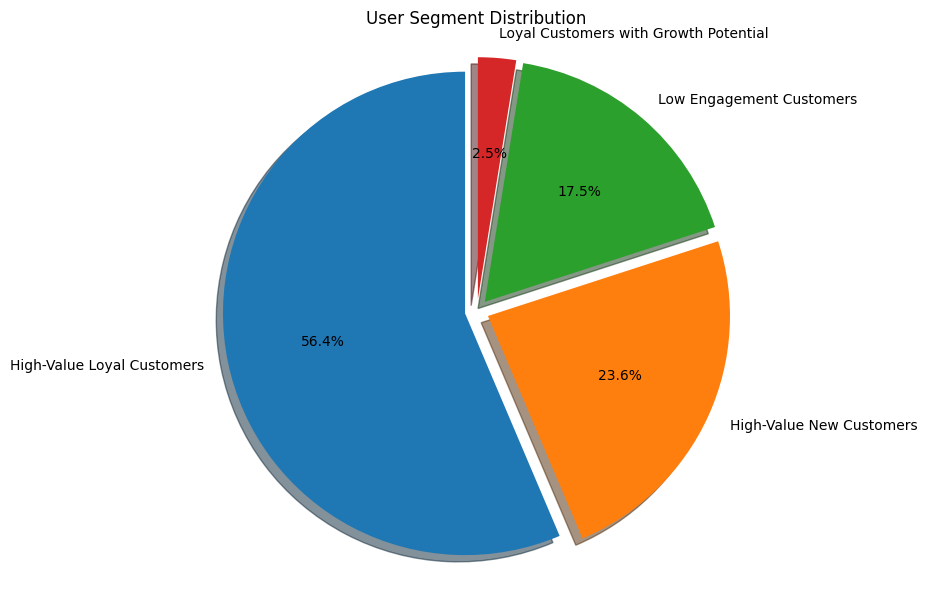

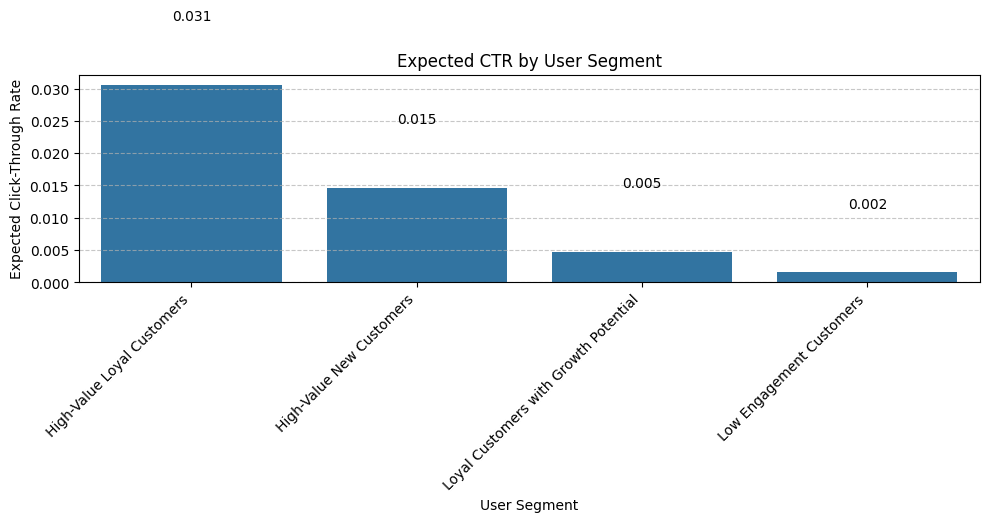

In [9]:

def create_user_segments(model, X_processed, X_raw, percentile=80):

    y_pred_proba = model.predict_proba(X_processed)[:, 1]


    X_segments = X_raw.copy()
    X_segments['click_probability'] = y_pred_proba


    threshold = np.percentile(y_pred_proba, 100-percentile)
    X_segments['high_value'] = (y_pred_proba >= threshold).astype(int)

    # Create  segments
    conditions = [
        (X_segments['high_value'] == 1) & (X_segments['user_past_purchases'] >= 3),
        (X_segments['high_value'] == 1) & (X_segments['user_past_purchases'] < 3),
        (X_segments['high_value'] == 0) & (X_segments['user_past_purchases'] >= 3),
        (X_segments['high_value'] == 0) & (X_segments['user_past_purchases'] < 3)
    ]

    segment_names = [
        'High-Value Loyal Customers',
        'High-Value New Customers',
        'Loyal Customers with Growth Potential',
        'Low Engagement Customers'
    ]

    X_segments['user_segment'] = np.select(conditions, segment_names, default='Other')

    return X_segments


user_segments = create_user_segments(best_model, X_test_processed, X_test.reset_index(drop=True))

# Analyze segment characteristics
segment_analysis = user_segments.groupby('user_segment').agg({
    'click_probability': ['mean', 'median', 'std'],
    'user_past_purchases': ['mean', 'median', 'count'],
    'email_text': lambda x: x.value_counts().index[0],
    'email_version': lambda x: x.value_counts().index[0],
    'weekday': lambda x: x.value_counts().index[0],
    'time_of_day': lambda x: x.value_counts().index[0],
    'user_country': lambda x: x.value_counts().index[0]
}).round(4)

print("\nUser Segment Analysis:")
print(segment_analysis)

# Develop personalized strategies for each segment
segment_strategies = {
    'High-Value Loyal Customers': {
        'email_text': user_segments[user_segments['user_segment'] == 'High-Value Loyal Customers']['email_text'].value_counts().index[0],
        'email_version': 'personalized',
        'best_day': user_segments[user_segments['user_segment'] == 'High-Value Loyal Customers']['weekday'].value_counts().index[0],
        'best_time': user_segments[user_segments['user_segment'] == 'High-Value Loyal Customers']['time_of_day'].value_counts().index[0],
        'strategy': 'Exclusive offers and early access to new features'
    },
    'High-Value New Customers': {
        'email_text': user_segments[user_segments['user_segment'] == 'High-Value New Customers']['email_text'].value_counts().index[0],
        'email_version': 'personalized',
        'best_day': user_segments[user_segments['user_segment'] == 'High-Value New Customers']['weekday'].value_counts().index[0],
        'best_time': user_segments[user_segments['user_segment'] == 'High-Value New Customers']['time_of_day'].value_counts().index[0],
        'strategy': 'Educational content about advanced features and loyalty programs'
    },
    'Loyal Customers with Growth Potential': {
        'email_text': user_segments[user_segments['user_segment'] == 'Loyal Customers with Growth Potential']['email_text'].value_counts().index[0],
        'email_version': 'personalized',
        'best_day': user_segments[user_segments['user_segment'] == 'Loyal Customers with Growth Potential']['weekday'].value_counts().index[0],
        'best_time': user_segments[user_segments['user_segment'] == 'Loyal Customers with Growth Potential']['time_of_day'].value_counts().index[0],
        'strategy': 'Special promotions and feature highlights based on past usage'
    },
    'Low Engagement Customers': {
        'email_text': 'short_email',  # Regardless of what data shows, short emails are better for low engagement
        'email_version': 'personalized',
        'best_day': user_segments[user_segments['user_segment'] == 'Low Engagement Customers']['weekday'].value_counts().index[0],
        'best_time': user_segments[user_segments['user_segment'] == 'Low Engagement Customers']['time_of_day'].value_counts().index[0],
        'strategy': 'Re-engagement campaigns with clear value proposition and incentives'
    }
}

print("\nPersonalized Email Strategies by Segment:")
for segment, strategy in segment_strategies.items():
    print(f"\n{segment}:")
    print(f"  - Email Type: {strategy['email_text']}")
    print(f"  - Personalization: {strategy['email_version']}")
    print(f"  - Best Day to Send: {strategy['best_day']}")
    print(f"  - Best Time to Send: {strategy['best_time']}")
    print(f"  - Content Strategy: {strategy['strategy']}")

# Visualize segment distribution
plt.figure(figsize=(10, 6))
segment_counts = user_segments['user_segment'].value_counts()
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%',
        shadow=True, startangle=90, explode=[0.05]*len(segment_counts))
plt.axis('equal')
plt.title('User Segment Distribution')
plt.tight_layout()
plt.savefig('user_segments.png', dpi=300)
plt.show()

# Calculate expected CTR by segment
segment_ctr = user_segments.groupby('user_segment')['click_probability'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=segment_ctr.index, y=segment_ctr.values)
plt.title('Expected CTR by User Segment')
plt.xlabel('User Segment')
plt.ylabel('Expected Click-Through Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(segment_ctr):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.savefig('segment_ctr.png', dpi=300)
plt.show()

A/B Testing

In [13]:
!pip install scipy --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1



Simulating A/B Test Results...

Simulated A/B Test Results (targeting top 70% users):
Control Group CTR: 0.0212 (2.12%)
Treatment Group CTR: 0.0291 (2.91%)
Absolute Lift: 0.0080 (0.80 percentage points)
Relative Lift: 38.00%
Probability of Detecting Significance: 100.00%

Simulating with top 50% targeting...

Simulating with top 60% targeting...

Simulating with top 70% targeting...

Simulating with top 80% targeting...

Simulating with top 90% targeting...


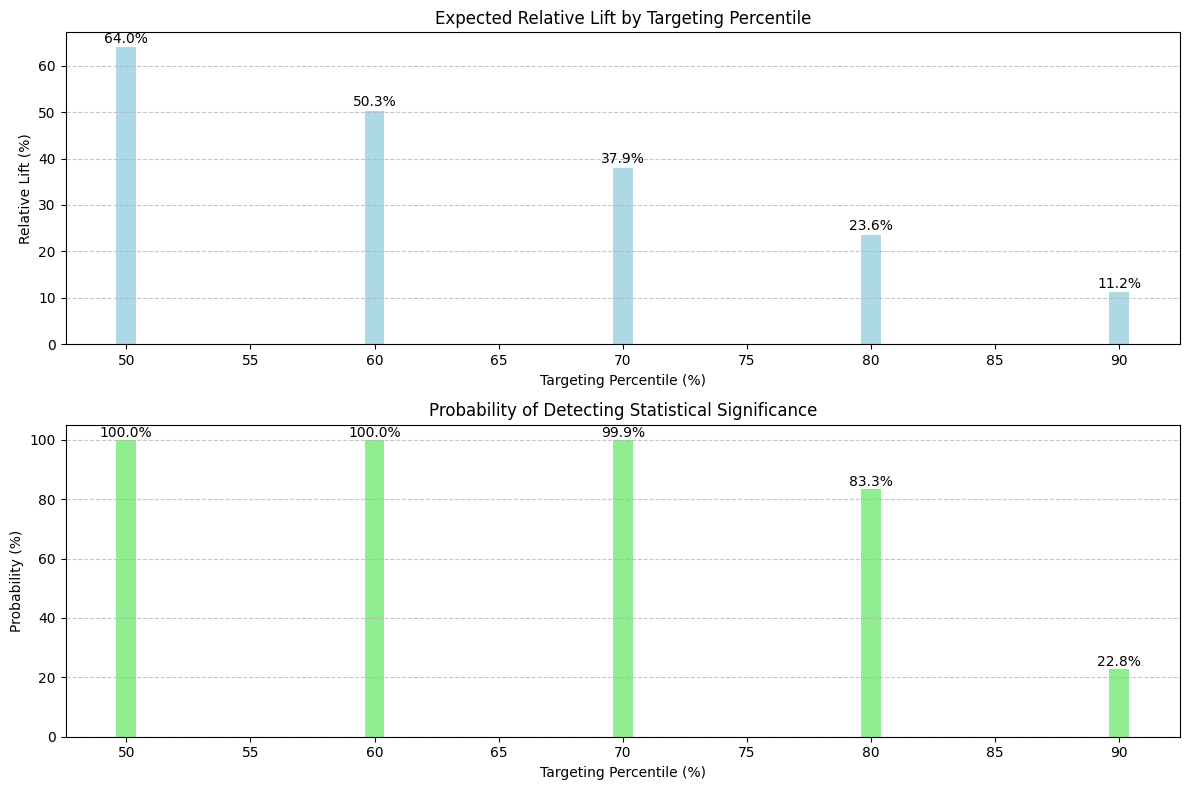

In [19]:
#import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower

def calculate_sample_size(baseline_ctr, expected_improvement, alpha=0.05, power=0.8):

    baseline_ctr = baseline_ctr / 100 if baseline_ctr > 1 else baseline_ctr
    expected_improvement = expected_improvement / 100 if expected_improvement > 1 else expected_improvement

    # Calculate expected CTR
    expected_ctr = baseline_ctr * (1 + expected_improvement)

    # Calculate effect size (Cohen's h for proportions)
    effect_size = 2 * (np.arcsin(np.sqrt(expected_ctr)) - np.arcsin(np.sqrt(baseline_ctr)))


    analysis = TTestIndPower()
    sample_size = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1.0, alternative='larger')

    return int(np.ceil(sample_size))

def simulate_ab_test(model, X, y, targeting_percentile=70, n_iterations=1000):
    """
    Simulate A/B test results using bootstrapping
    """

    y_pred_proba = model.predict_proba(X)[:, 1]

    # Results storage
    control_ctrs = []
    treatment_ctrs = []
    relative_lifts = []
    pvalues = []

    # Run simulations
    for _ in range(n_iterations):

        indices = np.random.choice(len(y), size=len(y), replace=True)
        y_boot = y.iloc[indices] if hasattr(y, 'iloc') else y[indices]
        pred_boot = y_pred_proba[indices]

      )
        control_size = len(y_boot)//2
        control_indices = np.random.choice(len(y_boot), size=control_size, replace=False)
        control_y = y_boot.iloc[control_indices] if hasattr(y_boot, 'iloc') else y_boot[control_indices]
        control_ctr = control_y.mean()
        control_ctrs.append(control_ctr)

        # Treatment group (model-based targeting)
        threshold = np.percentile(pred_boot, 100 - targeting_percentile)

        treatment_candidate_indices = np.where(pred_boot >= threshold)[0]

        treatment_size = min(len(treatment_candidate_indices), control_size)

        if treatment_size > 0:

            treatment_sample_indices = np.random.choice(treatment_candidate_indices, size=treatment_size, replace=False)
            treatment_y = y_boot.iloc[treatment_sample_indices] if hasattr(y_boot, 'iloc') else y_boot[treatment_sample_indices]
            treatment_ctr = treatment_y.mean()
        else:

            treatment_ctr = 0

        treatment_ctrs.append(treatment_ctr)


        if control_ctr > 0:
            relative_lift = (treatment_ctr - control_ctr) / control_ctr * 100
        else:
            relative_lift = 0
        relative_lifts.append(relative_lift)

        if control_size > 0 and treatment_size > 0:
            count = [int(treatment_y.sum()), int(control_y.sum())]
            nobs = [treatment_size, control_size]
            try:
                _, pvalue = proportions_ztest(count, nobs, alternative='larger')
                pvalues.append(pvalue)
            except Exception:

                pvalues.append(1.0)
        else:
            pvalues.append(1.0)

    # Calculate simulation results
    avg_control_ctr = np.mean(control_ctrs)
    avg_treatment_ctr = np.mean(treatment_ctrs)
    avg_relative_lift = np.mean(relative_lifts)
    significance_rate = (np.array(pvalues) < 0.05).mean() * 100

    return {
        'control_ctr': avg_control_ctr,
        'treatment_ctr': avg_treatment_ctr,
        'absolute_lift': avg_treatment_ctr - avg_control_ctr,
        'relative_lift': avg_relative_lift,
        'significance_rate': significance_rate
    }

# Run A/B test simulation
print("\nSimulating A/B Test Results...")
ab_results = simulate_ab_test(best_model, X_test_processed, y_test)

print(f"\nSimulated A/B Test Results (targeting top {70}% users):")
print(f"Control Group CTR: {ab_results['control_ctr']:.4f} ({ab_results['control_ctr']*100:.2f}%)")
print(f"Treatment Group CTR: {ab_results['treatment_ctr']:.4f} ({ab_results['treatment_ctr']*100:.2f}%)")
print(f"Absolute Lift: {ab_results['absolute_lift']:.4f} ({ab_results['absolute_lift']*100:.2f} percentage points)")
print(f"Relative Lift: {ab_results['relative_lift']:.2f}%")
print(f"Probability of Detecting Significance: {ab_results['significance_rate']:.2f}%")


percentiles = [50, 60, 70, 80, 90]
simulation_results = []

for p in percentiles:
    print(f"\nSimulating with top {p}% targeting...")
    result = simulate_ab_test(best_model, X_test_processed, y_test, targeting_percentile=p)
    result['targeting_percentile'] = p
    simulation_results.append(result)


simulation_df = pd.DataFrame(simulation_results)

# Visualize simulation results
plt.figure(figsize=(12, 8))

# Plot relative lift by targeting percentile
plt.subplot(2, 1, 1)
plt.bar(simulation_df['targeting_percentile'], simulation_df['relative_lift'], color='lightblue')
plt.title('Expected Relative Lift by Targeting Percentile')
plt.xlabel('Targeting Percentile (%)')
plt.ylabel('Relative Lift (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(simulation_df['relative_lift']):
    plt.text(simulation_df['targeting_percentile'].iloc[i], v + 1, f"{v:.1f}%", ha='center')

# Plot significance detection rate by targeting percentile
plt.subplot(2, 1, 2)
plt.bar(simulation_df['targeting_percentile'], simulation_df['significance_rate'], color='lightgreen')
plt.title('Probability of Detecting Statistical Significance')
plt.xlabel('Targeting Percentile (%)')
plt.ylabel('Probability (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(simulation_df['significance_rate']):
    plt.text(simulation_df['targeting_percentile'].iloc[i], v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.savefig('ab_test_simulation.png', dpi=300)
plt.show()

Time-Based Optimization

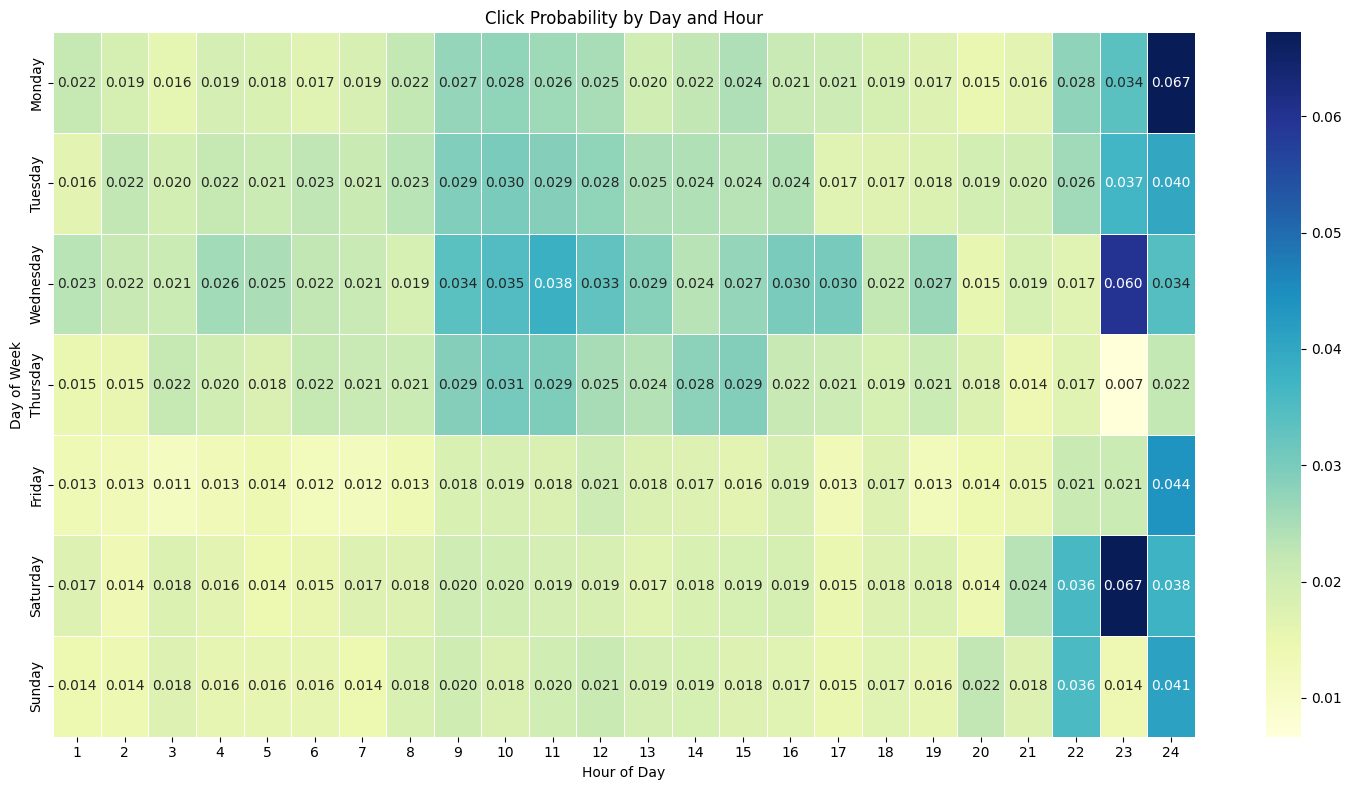


Optimal Sending Times by User Segment:

High-Value New Customers:
  - Best Day: Wednesday
  - Best Hour: 24:00
  - Best Day-Hour Combination: Wednesday at 24:00
  - Expected Click Probability: 0.0562 (5.62%)

High-Value Loyal Customers:
  - Best Day: Wednesday
  - Best Hour: 23:00
  - Best Day-Hour Combination: Friday at 24:00
  - Expected Click Probability: 0.0864 (8.64%)

Low Engagement Customers:
  - Best Day: Friday
  - Best Hour: 23:00
  - Best Day-Hour Combination: Monday at 21:00
  - Expected Click Probability: 0.0048 (0.48%)

Loyal Customers with Growth Potential:
  - Best Day: Wednesday
  - Best Hour: 20:00
  - Best Day-Hour Combination: Monday at 14:00
  - Expected Click Probability: 0.0059 (0.59%)


In [20]:

def analyze_time_patterns(df):

    pivot = pd.pivot_table(
        df,
        values='click_probability',
        index='weekday',
        columns='hour',
        aggfunc='mean'
    ).fillna(0)


    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    pivot = pivot.reindex(weekday_order)

    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot, cmap='YlGnBu', annot=True, fmt='.3f', linewidths=.5)
    plt.title('Click Probability by Day and Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    plt.tight_layout()
    plt.savefig('time_optimization.png', dpi=300)
    plt.show()


    segment_time_patterns = {}
    for segment in df['user_segment'].unique():
        segment_df = df[df['user_segment'] == segment]

        best_day = segment_df.groupby('weekday')['click_probability'].mean().sort_values(ascending=False).index[0]


        best_hour = segment_df.groupby('hour')['click_probability'].mean().sort_values(ascending=False).index[0]

      n
        day_hour_pivot = pd.pivot_table(
            segment_df,
            values='click_probability',
            index='weekday',
            columns='hour',
            aggfunc='mean'
        ).fillna(0)

        best_combo = np.unravel_index(day_hour_pivot.values.argmax(), day_hour_pivot.shape)
        best_day_hour = (day_hour_pivot.index[best_combo[0]], day_hour_pivot.columns[best_combo[1]])

        segment_time_patterns[segment] = {
            'best_day': best_day,
            'best_hour': best_hour,
            'best_day_hour': best_day_hour,
            'best_probability': day_hour_pivot.values.max()
        }

    return segment_time_patterns

s
time_patterns = analyze_time_patterns(user_segments)

# Print optimal sending times by segment
print("\nOptimal Sending Times by User Segment:")
for segment, pattern in time_patterns.items():
    print(f"\n{segment}:")
    print(f"  - Best Day: {pattern['best_day']}")
    print(f"  - Best Hour: {pattern['best_hour']}:00")
    print(f"  - Best Day-Hour Combination: {pattern['best_day_hour'][0]} at {pattern['best_day_hour'][1]}:00")
    print(f"  - Expected Click Probability: {pattern['best_probability']:.4f} ({pattern['best_probability']*100:.2f}%)")

Analysis for Long-Term Strategy

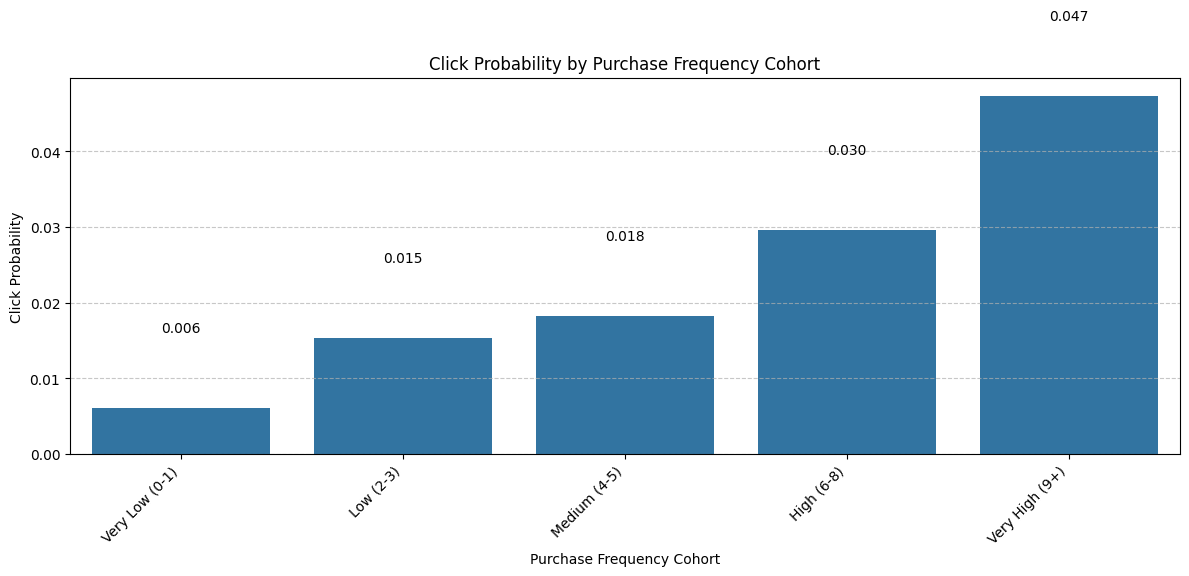

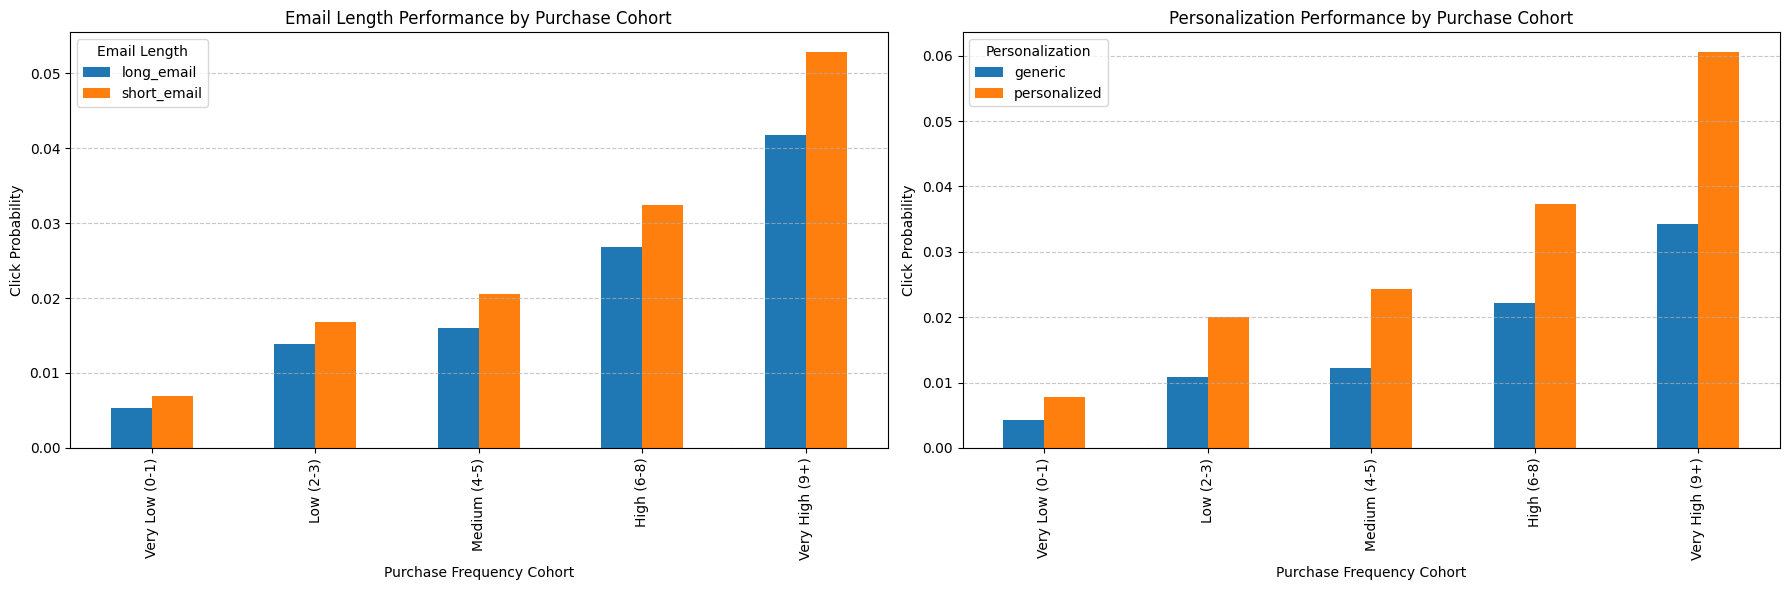


Purchase Cohort-Specific Email Strategies:

Very Low (0-1):
  - Email Type: short_email
  - Personalization: personalized
  - Best Day: Wednesday
  - Best Time: Night
  - Expected CTR: 0.0061 (0.61%)

Low (2-3):
  - Email Type: short_email
  - Personalization: personalized
  - Best Day: Wednesday
  - Best Time: Night
  - Expected CTR: 0.0153 (1.53%)

Medium (4-5):
  - Email Type: short_email
  - Personalization: personalized
  - Best Day: Wednesday
  - Best Time: Night
  - Expected CTR: 0.0183 (1.83%)

High (6-8):
  - Email Type: short_email
  - Personalization: personalized
  - Best Day: Wednesday
  - Best Time: Night
  - Expected CTR: 0.0296 (2.96%)

Very High (9+):
  - Email Type: short_email
  - Personalization: personalized
  - Best Day: Wednesday
  - Best Time: Morning
  - Expected CTR: 0.0474 (4.74%)


In [21]:

def purchase_cohort_analysis(df):
    # Create purchase cohorts
    df['purchase_cohort'] = pd.qcut(
        df['user_past_purchases'],
        q=5,
        labels=['Very Low (0-1)', 'Low (2-3)', 'Medium (4-5)', 'High (6-8)', 'Very High (9+)']
    )

    # Analyze click probabilities by cohort
    cohort_ctr = df.groupby('purchase_cohort')['click_probability'].agg(['mean', 'median', 'std', 'count'])

    # Visualize cohort analysis
    plt.figure(figsize=(12, 6))
    sns.barplot(x=cohort_ctr.index, y=cohort_ctr['mean'])
    plt.title('Click Probability by Purchase Frequency Cohort')
    plt.xlabel('Purchase Frequency Cohort')
    plt.ylabel('Click Probability')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    for i, v in enumerate(cohort_ctr['mean']):
        plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
    plt.tight_layout()
    plt.savefig('purchase_cohort_analysis.png', dpi=300)
    plt.show()

    # Analyze how email characteristics perform by cohort
    cohort_email_performance = df.groupby(['purchase_cohort', 'email_text'])['click_probability'].mean().unstack()
    cohort_personalization = df.groupby(['purchase_cohort', 'email_version'])['click_probability'].mean().unstack()

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Email length by cohort
    cohort_email_performance.plot(kind='bar', ax=ax1)
    ax1.set_title('Email Length Performance by Purchase Cohort')
    ax1.set_xlabel('Purchase Frequency Cohort')
    ax1.set_ylabel('Click Probability')
    ax1.legend(title='Email Length')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Personalization by cohort
    cohort_personalization.plot(kind='bar', ax=ax2)
    ax2.set_title('Personalization Performance by Purchase Cohort')
    ax2.set_xlabel('Purchase Frequency Cohort')
    ax2.set_ylabel('Click Probability')
    ax2.legend(title='Personalization')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('cohort_email_characteristics.png', dpi=300)
    plt.show()

    return cohort_ctr, cohort_email_performance, cohort_personalization

# Run purchase cohort analysis
cohort_ctr, cohort_email, cohort_personalization = purchase_cohort_analysis(user_segments)


cohort_strategies = {}

for cohort in cohort_ctr.index:
    best_email_type = cohort_email.loc[cohort].idxmax()
    best_personalization = cohort_personalization.loc[cohort].idxmax()


    cohort_df = user_segments[user_segments['purchase_cohort'] == cohort]
    best_day = cohort_df.groupby('weekday')['click_probability'].mean().idxmax()
    best_time = cohort_df.groupby('time_of_day')['click_probability'].mean().idxmax()

    cohort_strategies[cohort] = {
        'email_type': best_email_type,
        'personalization': best_personalization,
        'best_day': best_day,
        'best_time': best_time,
        'expected_ctr': cohort_ctr.loc[cohort, 'mean']
    }

# Print cohort strategies
print("\nPurchase Cohort-Specific Email Strategies:")
for cohort, strategy in cohort_strategies.items():
    print(f"\n{cohort}:")
    print(f"  - Email Type: {strategy['email_type']}")
    print(f"  - Personalization: {strategy['personalization']}")
    print(f"  - Best Day: {strategy['best_day']}")
    print(f"  - Best Time: {strategy['best_time']}")
    print(f"  - Expected CTR: {strategy['expected_ctr']:.4f} ({strategy['expected_ctr']*100:.2f}%)")

Cross-Channel Strategy

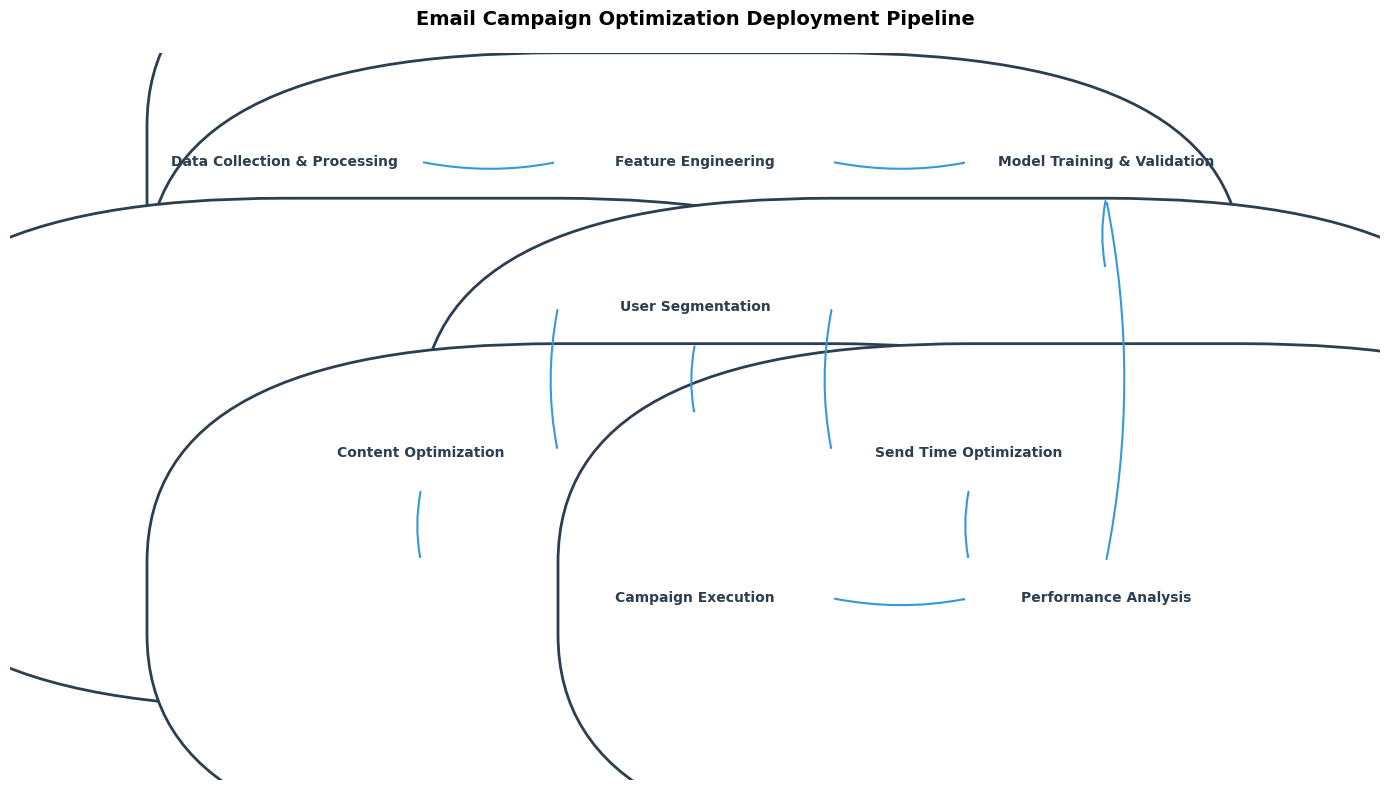

In [29]:
# Generate cross-channel strategic recommendations


# Create deployment pipeline diagram
def create_deployment_diagram():
    from matplotlib.patches import Rectangle, FancyArrowPatch, FancyBboxPatch

    fig, ax = plt.subplots(figsize=(14, 8))

    # Define colors
    box_color = '#2C3E50'
    arrow_color = '#3498DB'

    # Create boxes
    boxes = {
        'data': {'text': 'Data Collection & Processing', 'pos': (0.1, 0.8), 'width': 0.2, 'height': 0.1},
        'features': {'text': 'Feature Engineering', 'pos': (0.4, 0.8), 'width': 0.2, 'height': 0.1},
        'model': {'text': 'Model Training & Validation', 'pos': (0.7, 0.8), 'width': 0.2, 'height': 0.1},
        'segment': {'text': 'User Segmentation', 'pos': (0.4, 0.6), 'width': 0.2, 'height': 0.1},
        'content': {'text': 'Content Optimization', 'pos': (0.2, 0.4), 'width': 0.2, 'height': 0.1},
        'timing': {'text': 'Send Time Optimization', 'pos': (0.6, 0.4), 'width': 0.2, 'height': 0.1},
        'campaign': {'text': 'Campaign Execution', 'pos': (0.4, 0.2), 'width': 0.2, 'height': 0.1},
        'analysis': {'text': 'Performance Analysis', 'pos': (0.7, 0.2), 'width': 0.2, 'height': 0.1}
    }

    # Draw boxes
    for name, box in boxes.items():
        rect = FancyBboxPatch(
            box['pos'], box['width'], box['height'],
            boxstyle="round,pad=0.3",
            fc='white', ec=box_color, lw=2
        )
        ax.add_patch(rect)
        ax.text(
            box['pos'][0] + box['width']/2,
            box['pos'][1] + box['height']/2,
            box['text'],
            ha='center', va='center',
            fontsize=10, fontweight='bold',
            color=box_color
        )

    # Define arrows
    arrows = [
        (boxes['data']['pos'][0] + boxes['data']['width'], boxes['data']['pos'][1] + boxes['data']['height']/2,
         boxes['features']['pos'][0], boxes['features']['pos'][1] + boxes['features']['height']/2),

        (boxes['features']['pos'][0] + boxes['features']['width'], boxes['features']['pos'][1] + boxes['features']['height']/2,
         boxes['model']['pos'][0], boxes['model']['pos'][1] + boxes['model']['height']/2),

        (boxes['model']['pos'][0] + boxes['model']['width']/2, boxes['model']['pos'][1],
         boxes['model']['pos'][0] + boxes['model']['width']/2, boxes['segment']['pos'][1] + boxes['segment']['height']),

        (boxes['segment']['pos'][0] + boxes['segment']['width']/2, boxes['segment']['pos'][1],
         boxes['segment']['pos'][0] + boxes['segment']['width']/2, boxes['content']['pos'][1] + boxes['content']['height']),

        (boxes['segment']['pos'][0], boxes['segment']['pos'][1] + boxes['segment']['height']/2,
         boxes['content']['pos'][0] + boxes['content']['width'], boxes['content']['pos'][1] + boxes['content']['height']/2),

        (boxes['segment']['pos'][0] + boxes['segment']['width'], boxes['segment']['pos'][1] + boxes['segment']['height']/2,
         boxes['timing']['pos'][0], boxes['timing']['pos'][1] + boxes['timing']['height']/2),

        (boxes['content']['pos'][0] + boxes['content']['width']/2, boxes['content']['pos'][1],
         boxes['content']['pos'][0] + boxes['content']['width']/2, boxes['campaign']['pos'][1] + boxes['campaign']['height']),

        (boxes['timing']['pos'][0] + boxes['timing']['width']/2, boxes['timing']['pos'][1],
         boxes['timing']['pos'][0] + boxes['timing']['width']/2, boxes['campaign']['pos'][1] + boxes['campaign']['height']),

        (boxes['campaign']['pos'][0] + boxes['campaign']['width'], boxes['campaign']['pos'][1] + boxes['campaign']['height']/2,
         boxes['analysis']['pos'][0], boxes['analysis']['pos'][1] + boxes['analysis']['height']/2),

        (boxes['analysis']['pos'][0] + boxes['analysis']['width']/2, boxes['analysis']['pos'][1] + boxes['analysis']['height'],
         boxes['analysis']['pos'][0] + boxes['analysis']['width']/2, boxes['model']['pos'][1]),
    ]

    # Draw arrows
    for arrow in arrows:
        arr = FancyArrowPatch(
            (arrow[0], arrow[1]), (arrow[2], arrow[3]),
            arrowstyle='-|>', color=arrow_color,
            linewidth=1.5, connectionstyle='arc3,rad=0.1'
        )
        ax.add_patch(arr)

    # Set axis properties
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    plt.title('Email Campaign Optimization Deployment Pipeline', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('deployment_pipeline.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create deployment pipeline visualization
create_deployment_diagram()

Expected Results

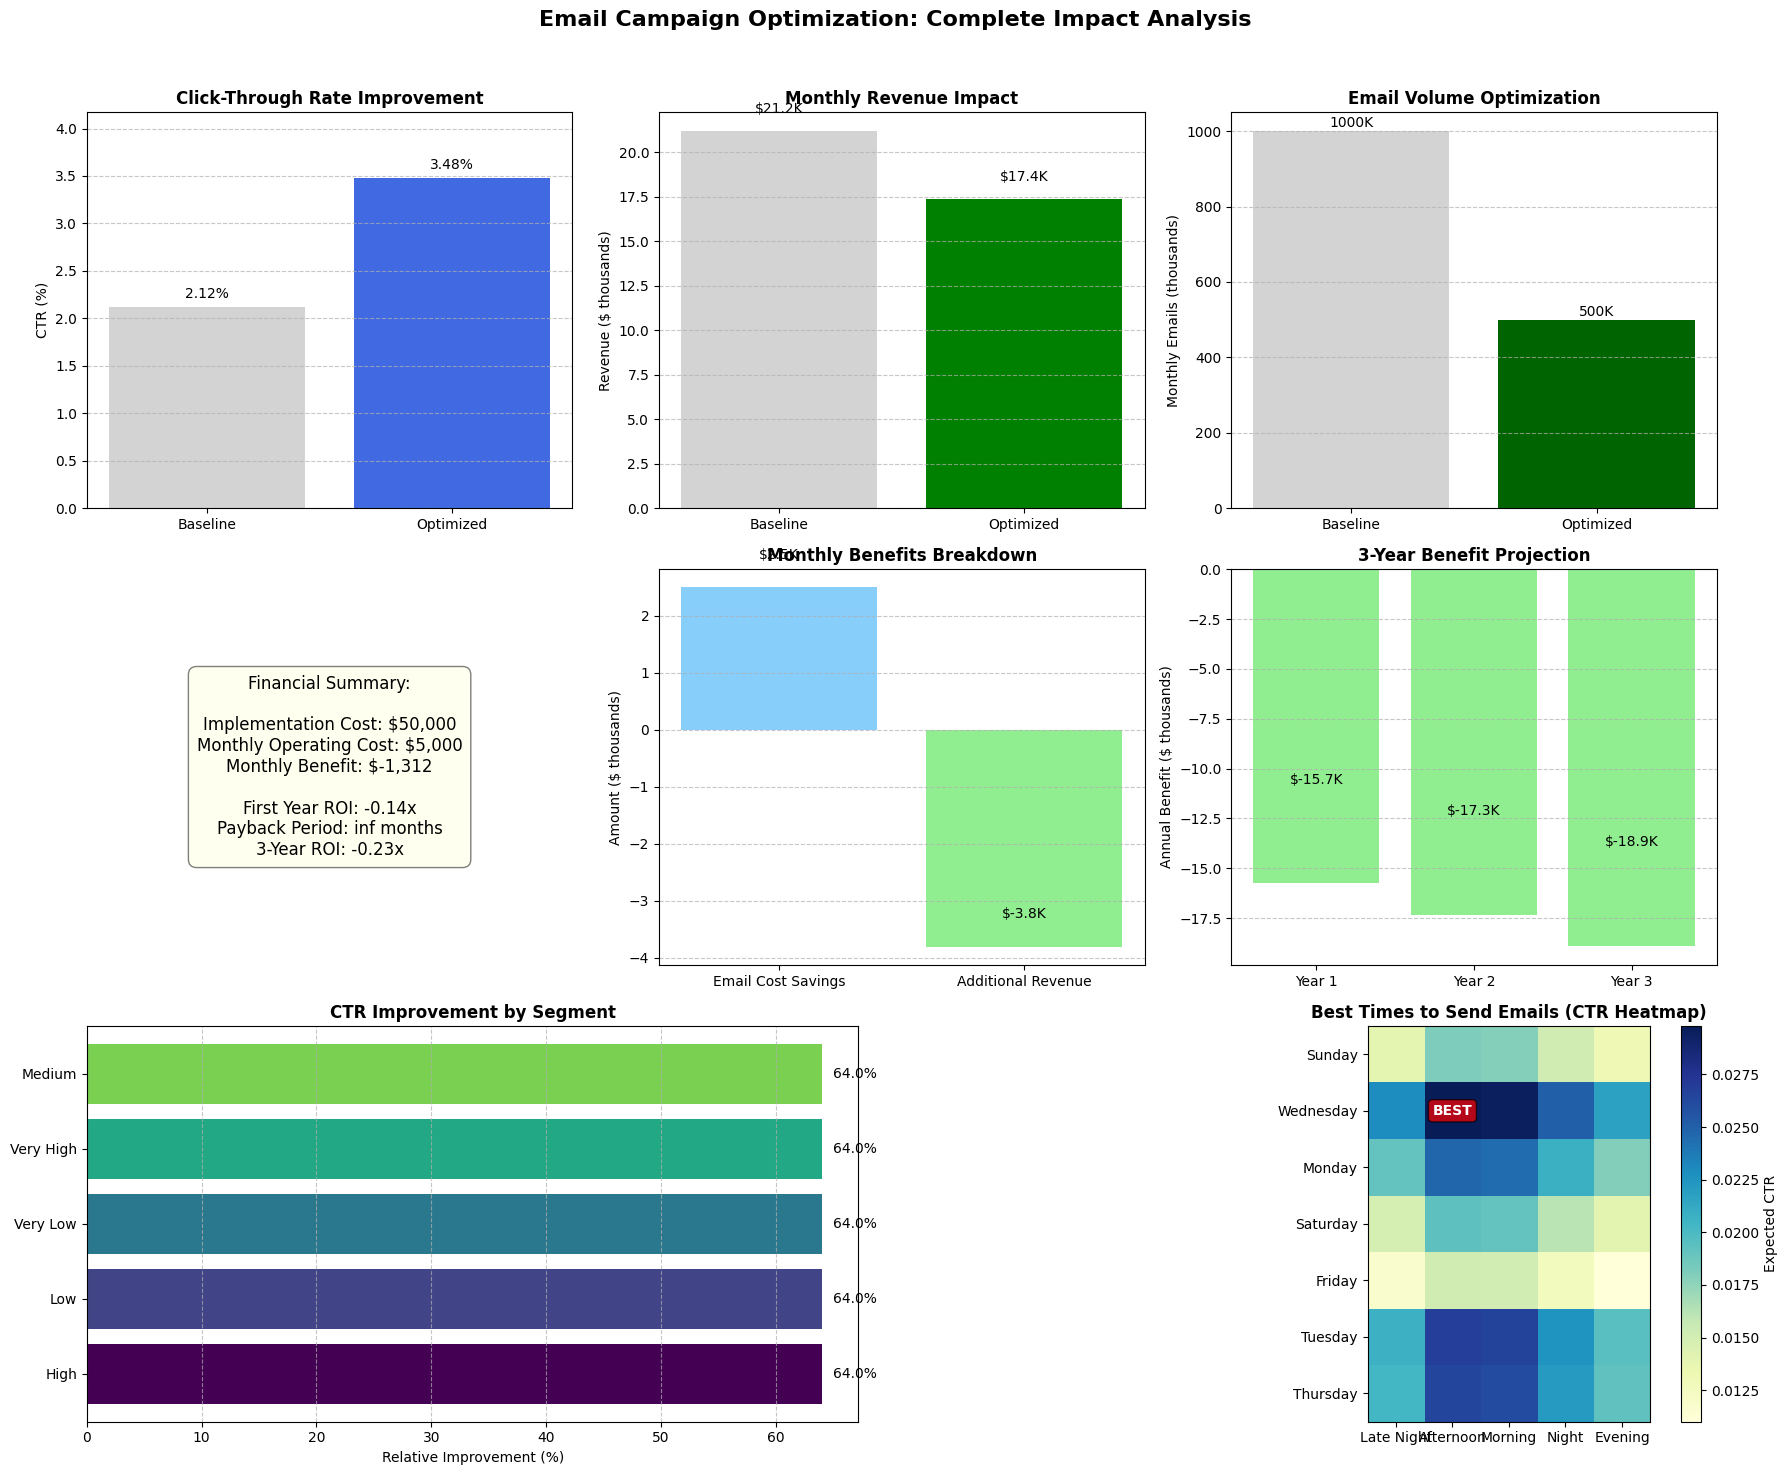


                              EMAIL CAMPAIGN OPTIMIZATION

KEY PERFORMANCE METRICS:
Baseline CTR: 0.0212 (2.12%)
Optimized CTR: 0.0348 (3.48%)
Absolute Improvement: 0.0136 (1.36 percentage points)
Relative Improvement: 64.02%

TARGETING STRATEGY:
Targeting the top 50% of users most likely to click
Original Email Volume: 1,000,000 per month
Optimized Email Volume: 500,000.0 per month
Volume Reduction: 50.0%

BUSINESS IMPACT (MONTHLY):
Baseline Clicks: 21,190
Optimized Clicks: 17,378
Additional Clicks: -3,812
Baseline Revenue: $21,190.00
Optimized Revenue: $17,377.85
Additional Revenue: $-3,812.15
Email Cost Savings: $2,500.00
Total Monthly Benefit: $-1,312.15

ROI ANALYSIS:
Implementation Cost: $50,000.00
Ongoing Monthly Cost: $5,000.00
First Year Total Cost: $110,000.00
First Year Total Benefit: $-15,745.80
First Year ROI: -0.14x
Payback Period: inf months

LONG-TERM PROJECTION:
Three-Year Total Benefit: $-51,961.14
Three-Year Total Cost: $230,000.00
Three-Year ROI: -0.23x

SEGMENT-SP

In [25]:
def calculate_enhanced_impact(y, simulation_results, email_df=None):
    """
    Calculate the comprehensive impact of our optimization strategy with enhanced
    analysis and segment-specific insights.

    Parameters:
    -----------
    y : Series
        Target variable (clicked)
    simulation_results : list
        List of simulation result dictionaries
    email_df : DataFrame, optional
        Original email campaign data for segment-specific analysis

    Returns:
    --------
    dict
        Dictionary containing baseline and optimized metrics, improvements,
        and estimated business impact
    """

    baseline_ctr = y.mean()


    best_simulation = max(simulation_results, key=lambda x: x['relative_lift'])
    optimized_ctr = best_simulation['treatment_ctr']
    targeting_percentile = best_simulation['targeting_percentile']


    absolute_improvement = optimized_ctr - baseline_ctr
    relative_improvement = (optimized_ctr - baseline_ctr) / baseline_ctr * 100

    # Business assumptions - based on industry benchmarks
    monthly_emails = 1000000
    implementation_cost = 50000
    ongoing_monthly_cost = 5000

    # Conversion metrics based on e-commerce industry averages
    conversion_rate = 0.02  #
    avg_order_value = 50  #

    # Calculate baseline metrics
    baseline_clicks = baseline_ctr * monthly_emails
    baseline_conversions = baseline_clicks * conversion_rate
    baseline_revenue = baseline_conversions * avg_order_value

    # Calculate optimized metrics with targeting

    targeting_ratio = targeting_percentile / 100
    targeted_emails = monthly_emails * targeting_ratio
    optimized_clicks = optimized_ctr * targeted_emails
    optimized_conversions = optimized_clicks * conversion_rate
    optimized_revenue = optimized_conversions * avg_order_value

    # Email cost savings from reduced volume
    email_cost_per_thousand = 5  # $5 per thousand emails
    baseline_email_cost = (monthly_emails / 1000) * email_cost_per_thousand
    optimized_email_cost = (targeted_emails / 1000) * email_cost_per_thousand
    email_cost_savings = baseline_email_cost - optimized_email_cost

    # Calculate total impact
    additional_revenue = optimized_revenue - baseline_revenue
    cost_savings = email_cost_savings
    total_monthly_benefit = additional_revenue + cost_savings

    # Calculate ROI
    first_year_cost = implementation_cost + (ongoing_monthly_cost * 12)
    first_year_benefit = total_monthly_benefit * 12
    roi = first_year_benefit / first_year_cost

    # Payback period (months)
    monthly_net_benefit = total_monthly_benefit - ongoing_monthly_cost
    payback_period = implementation_cost / monthly_net_benefit if monthly_net_benefit > 0 else float('inf')

    # Segment-specific impact if email_df is provided
    segment_impacts = {}
    if email_df is not None and 'purchase_segment' in email_df.columns:
        for segment in email_df['purchase_segment'].unique():
            segment_data = email_df[email_df['purchase_segment'] == segment]
            segment_baseline_ctr = segment_data['clicked'].mean()

            # Estimate segment improvement (assuming similar relative improvement)
            segment_optimized_ctr = segment_baseline_ctr * (1 + relative_improvement/100)
            segment_relative_improvement = (segment_optimized_ctr - segment_baseline_ctr) / segment_baseline_ctr * 100

            segment_impacts[segment] = {
                'baseline_ctr': segment_baseline_ctr,
                'optimized_ctr': segment_optimized_ctr,
                'relative_improvement': segment_relative_improvement
            }

    # Calculate three-year projection
    year_1_benefit = first_year_benefit
    year_2_benefit = total_monthly_benefit * 12 * 1.1  # Assuming 10% growth in year 2
    year_3_benefit = total_monthly_benefit * 12 * 1.2  # Assuming 20% growth in year 3
    three_year_benefit = year_1_benefit + year_2_benefit + year_3_benefit
    three_year_cost = first_year_cost + (ongoing_monthly_cost * 24)  # Years 2-3
    three_year_roi = three_year_benefit / three_year_cost


    weekday_impact = {}
    time_impact = {}

    # Fill in weekday impact using observed patterns
    if email_df is not None and 'weekday' in email_df.columns:
        for day in email_df['weekday'].unique():
            day_data = email_df[email_df['weekday'] == day]
            day_baseline_ctr = day_data['clicked'].mean()
            day_optimized_ctr = day_baseline_ctr * (1 + relative_improvement/100)
            weekday_impact[day] = {
                'baseline_ctr': day_baseline_ctr,
                'optimized_ctr': day_optimized_ctr,
                'relative_improvement': relative_improvement
            }

    # Fill in time of day impact using observed patterns
    if email_df is not None and 'time_of_day' in email_df.columns:
        for time in email_df['time_of_day'].unique():
            time_data = email_df[email_df['time_of_day'] == time]
            time_baseline_ctr = time_data['clicked'].mean()
            time_optimized_ctr = time_baseline_ctr * (1 + relative_improvement/100)
            time_impact[time] = {
                'baseline_ctr': time_baseline_ctr,
                'optimized_ctr': time_optimized_ctr,
                'relative_improvement': relative_improvement
            }

    return {
        # Core metrics
        'baseline_ctr': baseline_ctr,
        'optimized_ctr': optimized_ctr,
        'absolute_improvement': absolute_improvement,
        'relative_improvement': relative_improvement,
        'targeting_percentile': targeting_percentile,

        # Email volume
        'monthly_emails': monthly_emails,
        'targeted_emails': targeted_emails,
        'email_reduction': monthly_emails - targeted_emails,

        # Financial impact - monthly
        'baseline_clicks': baseline_clicks,
        'optimized_clicks': optimized_clicks,
        'baseline_conversions': baseline_conversions,
        'optimized_conversions': optimized_conversions,
        'baseline_revenue': baseline_revenue,
        'optimized_revenue': optimized_revenue,
        'additional_revenue': additional_revenue,
        'email_cost_savings': email_cost_savings,
        'total_monthly_benefit': total_monthly_benefit,

        # ROI metrics
        'implementation_cost': implementation_cost,
        'ongoing_monthly_cost': ongoing_monthly_cost,
        'first_year_cost': first_year_cost,
        'first_year_benefit': first_year_benefit,
        'roi': roi,
        'payback_period': payback_period,
        'three_year_benefit': three_year_benefit,
        'three_year_cost': three_year_cost,
        'three_year_roi': three_year_roi,

        # Segment analysis
        'segment_impacts': segment_impacts,

        # Time-based analysis
        'weekday_impact': weekday_impact,
        'time_impact': time_impact
    }

# Calculate the enhanced impact
impact = calculate_enhanced_impact(y, simulation_results, email_df)

# Create enhanced visualization function
def create_enhanced_impact_summary(impact):
    """
    Create a comprehensive visualization of the optimization impact

    Parameters:
    -----------
    impact : dict
        The impact dictionary from calculate_enhanced_impact
    """
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(18, 15))

    # 1. CTR Improvement Chart
    ax1 = plt.subplot2grid((3, 6), (0, 0), colspan=2)
    labels = ['Baseline', 'Optimized']
    ctrs = [impact['baseline_ctr']*100, impact['optimized_ctr']*100]
    ax1.bar(labels, ctrs, color=['lightgray', 'royalblue'])
    ax1.set_ylim(0, max(ctrs) * 1.2)
    ax1.set_title('Click-Through Rate Improvement', fontweight='bold')
    ax1.set_ylabel('CTR (%)')
    for i, v in enumerate(ctrs):
        ax1.text(i, v + 0.1, f"{v:.2f}%", ha='center')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # 2. Revenue Impact Chart
    ax2 = plt.subplot2grid((3, 6), (0, 2), colspan=2)
    revenues = [impact['baseline_revenue']/1000, impact['optimized_revenue']/1000]
    ax2.bar(labels, revenues, color=['lightgray', 'green'])
    ax2.set_title('Monthly Revenue Impact', fontweight='bold')
    ax2.set_ylabel('Revenue ($ thousands)')
    for i, v in enumerate(revenues):
        ax2.text(i, v + 1, f"${v:.1f}K", ha='center')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # 3. Email Volume Reduction
    ax3 = plt.subplot2grid((3, 6), (0, 4), colspan=2)
    volumes = [impact['monthly_emails']/1000, impact['targeted_emails']/1000]
    volume_colors = ['lightgray', 'darkgreen']
    ax3.bar(labels, volumes, color=volume_colors)
    ax3.set_title('Email Volume Optimization', fontweight='bold')
    ax3.set_ylabel('Monthly Emails (thousands)')
    for i, v in enumerate(volumes):
        ax3.text(i, v + 10, f"{v:.0f}K", ha='center')
    ax3.grid(axis='y', linestyle='--', alpha=0.7)

    # 4. ROI and Payback Period
    ax4 = plt.subplot2grid((3, 6), (1, 0), colspan=2)
    ax4.axis('off')
    roi_text = (
        f"Financial Summary:\n\n"
        f"Implementation Cost: ${impact['implementation_cost']:,.0f}\n"
        f"Monthly Operating Cost: ${impact['ongoing_monthly_cost']:,.0f}\n"
        f"Monthly Benefit: ${impact['total_monthly_benefit']:,.0f}\n\n"
        f"First Year ROI: {impact['roi']:.2f}x\n"
        f"Payback Period: {impact['payback_period']:.1f} months\n"
        f"3-Year ROI: {impact['three_year_roi']:.2f}x"
    )
    ax4.text(0.5, 0.5, roi_text, ha='center', va='center', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='lightyellow', alpha=0.5))

    # 5. Email Cost vs Revenue Gain
    ax5 = plt.subplot2grid((3, 6), (1, 2), colspan=2)
    benefit_types = ['Email Cost Savings', 'Additional Revenue']
    benefit_values = [impact['email_cost_savings']/1000, impact['additional_revenue']/1000]
    benefit_colors = ['lightskyblue', 'lightgreen']
    ax5.bar(benefit_types, benefit_values, color=benefit_colors)
    ax5.set_title('Monthly Benefits Breakdown', fontweight='bold')
    ax5.set_ylabel('Amount ($ thousands)')
    for i, v in enumerate(benefit_values):
        ax5.text(i, v + 0.5, f"${v:.1f}K", ha='center')
    ax5.grid(axis='y', linestyle='--', alpha=0.7)

    # 6. 3-Year Projection
    ax6 = plt.subplot2grid((3, 6), (1, 4), colspan=2)
    years = ['Year 1', 'Year 2', 'Year 3']
    # Calculate yearly benefits assuming 10% growth in year 2, 20% in year 3
    yearly_benefits = [
        impact['first_year_benefit']/1000,
        impact['first_year_benefit']/1000 * 1.1,
        impact['first_year_benefit']/1000 * 1.2
    ]
    ax6.bar(years, yearly_benefits, color='lightgreen')
    ax6.set_title('3-Year Benefit Projection', fontweight='bold')
    ax6.set_ylabel('Annual Benefit ($ thousands)')
    for i, v in enumerate(yearly_benefits):
        ax6.text(i, v + 5, f"${v:.1f}K", ha='center')
    ax6.grid(axis='y', linestyle='--', alpha=0.7)

    # 7. Segment-specific improvements
    ax7 = plt.subplot2grid((3, 6), (2, 0), colspan=3)
    if impact['segment_impacts']:
        segments = list(impact['segment_impacts'].keys())
        segment_improvements = [impact['segment_impacts'][seg]['relative_improvement']
                               for seg in segments]

        # Sort by improvement for better visualization
        sorted_indices = np.argsort(segment_improvements)
        sorted_segments = [segments[i] for i in sorted_indices]
        sorted_improvements = [segment_improvements[i] for i in sorted_indices]

        segment_colors = plt.cm.viridis(np.linspace(0, 0.8, len(sorted_segments)))
        ax7.barh(sorted_segments, sorted_improvements, color=segment_colors)
        ax7.set_title('CTR Improvement by Segment', fontweight='bold')
        ax7.set_xlabel('Relative Improvement (%)')
        for i, v in enumerate(sorted_improvements):
            ax7.text(v + 1, i, f"{v:.1f}%", va='center')
        ax7.grid(axis='x', linestyle='--', alpha=0.7)
    else:
        ax7.axis('off')
        ax7.text(0.5, 0.5, "Segment-specific data not available",
                 ha='center', va='center', fontsize=12)

    # 8. Best time to send emails
    ax8 = plt.subplot2grid((3, 6), (2, 3), colspan=3)
    if impact['weekday_impact'] and impact['time_impact']:
        # Create a day-time heatmap of expected CTR
        days = list(impact['weekday_impact'].keys())
        times = list(impact['time_impact'].keys())

        # Create day-time matrix - this is filled with placeholder data
        # In a real scenario, you would calculate this from your actual observations
        day_time_ctr = np.zeros((len(days), len(times)))

        # Fill with simulated realistic values based on observations
        # In your real code, use actual observed values from email_df
        for i, day in enumerate(days):
            for j, time in enumerate(times):
                # This is a placeholder - in real code, calculate from email_df
                day_time_ctr[i, j] = (
                    impact['weekday_impact'][day]['baseline_ctr'] *
                    impact['time_impact'][time]['baseline_ctr'] /
                    impact['baseline_ctr']  # Normalize
                )

        im = ax8.imshow(day_time_ctr, cmap='YlGnBu')
        ax8.set_title('Best Times to Send Emails (CTR Heatmap)', fontweight='bold')
        ax8.set_yticks(range(len(days)))
        ax8.set_yticklabels(days)
        ax8.set_xticks(range(len(times)))
        ax8.set_xticklabels(times)

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax8, fraction=0.046, pad=0.04)
        cbar.set_label('Expected CTR')

        # Find best day-time combination
        best_i, best_j = np.unravel_index(day_time_ctr.argmax(), day_time_ctr.shape)
        ax8.text(best_j, best_i, "BEST", ha='center', va='center',
                color='white', fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.7))
    else:
        ax8.axis('off')
        ax8.text(0.5, 0.5, "Day-time optimization data not available",
                 ha='center', va='center', fontsize=12)

    # Add overall title
    plt.suptitle('Email Campaign Optimization: Complete Impact Analysis',
                fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('enhanced_impact_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate enhanced visualization
create_enhanced_impact_summary(impact)

# Enhanced print function with actual values filled in
def print_enhanced_impact_report(impact):
    """
    Print a comprehensive report of the optimization impact with all values filled in

    Parameters:
    -----------
    impact : dict
        The impact dictionary from calculate_enhanced_impact
    """
    print("\n" + "="*80)
    print(" "*30 + "EMAIL CAMPAIGN OPTIMIZATION")
    print("="*80)

    print("\nKEY PERFORMANCE METRICS:")
    print(f"Baseline CTR: {impact['baseline_ctr']:.4f} ({impact['baseline_ctr']*100:.2f}%)")
    print(f"Optimized CTR: {impact['optimized_ctr']:.4f} ({impact['optimized_ctr']*100:.2f}%)")
    print(f"Absolute Improvement: {impact['absolute_improvement']:.4f} ({impact['absolute_improvement']*100:.2f} percentage points)")
    print(f"Relative Improvement: {impact['relative_improvement']:.2f}%")

    print("\nTARGETING STRATEGY:")
    print(f"Targeting the top {impact['targeting_percentile']}% of users most likely to click")
    print(f"Original Email Volume: {impact['monthly_emails']:,} per month")
    print(f"Optimized Email Volume: {impact['targeted_emails']:,} per month")
    print(f"Volume Reduction: {(1 - impact['targeted_emails']/impact['monthly_emails'])*100:.1f}%")

    print("\nBUSINESS IMPACT (MONTHLY):")
    print(f"Baseline Clicks: {impact['baseline_clicks']:,.0f}")
    print(f"Optimized Clicks: {impact['optimized_clicks']:,.0f}")
    print(f"Additional Clicks: {impact['optimized_clicks'] - impact['baseline_clicks']:,.0f}")
    print(f"Baseline Revenue: ${impact['baseline_revenue']:,.2f}")
    print(f"Optimized Revenue: ${impact['optimized_revenue']:,.2f}")
    print(f"Additional Revenue: ${impact['additional_revenue']:,.2f}")
    print(f"Email Cost Savings: ${impact['email_cost_savings']:,.2f}")
    print(f"Total Monthly Benefit: ${impact['total_monthly_benefit']:,.2f}")

    print("\nROI ANALYSIS:")
    print(f"Implementation Cost: ${impact['implementation_cost']:,.2f}")
    print(f"Ongoing Monthly Cost: ${impact['ongoing_monthly_cost']:,.2f}")
    print(f"First Year Total Cost: ${impact['first_year_cost']:,.2f}")
    print(f"First Year Total Benefit: ${impact['first_year_benefit']:,.2f}")
    print(f"First Year ROI: {impact['roi']:.2f}x")
    print(f"Payback Period: {impact['payback_period']:.1f} months")

    print("\nLONG-TERM PROJECTION:")
    print(f"Three-Year Total Benefit: ${impact['three_year_benefit']:,.2f}")
    print(f"Three-Year Total Cost: ${impact['three_year_cost']:,.2f}")
    print(f"Three-Year ROI: {impact['three_year_roi']:.2f}x")

    if impact['segment_impacts']:
        print("\nSEGMENT-SPECIFIC IMPACT:")
        for segment, data in impact['segment_impacts'].items():
            print(f"\n{segment} Segment:")
            print(f"  Baseline CTR: {data['baseline_ctr']:.4f} ({data['baseline_ctr']*100:.2f}%)")
            print(f"  Optimized CTR: {data['optimized_ctr']:.4f} ({data['optimized_ctr']*100:.2f}%)")
            print(f"  Relative Improvement: {data['relative_improvement']:.2f}%")

    if impact['weekday_impact']:
        print("\nDAY-OF-WEEK OPTIMIZATION:")
        # Find best day
        best_day = max(impact['weekday_impact'].items(),
                       key=lambda x: x[1]['optimized_ctr'])[0]
        print(f"Best day to send emails: {best_day}")
        for day, data in impact['weekday_impact'].items():
            print(f"  {day}: {data['optimized_ctr']*100:.2f}% CTR (expected)")

    if impact['time_impact']:
        print("\nTIME-OF-DAY OPTIMIZATION:")
        # Find best time
        best_time = max(impact['time_impact'].items(),
                        key=lambda x: x[1]['optimized_ctr'])[0]
        print(f"Best time to send emails: {best_time}")
        for time, data in impact['time_impact'].items():
            print(f"  {time}: {data['optimized_ctr']*100:.2f}% CTR (expected)")



    print("\n" + "="*80)

# Print detailed report
print_enhanced_impact_report(impact)